## DEEPFAKE DETECTION

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("manjilkarki/deepfake-and-real-images")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'deepfake-and-real-images' dataset.
Path to dataset files: /kaggle/input/deepfake-and-real-images


In [ ]:
import os

# print(os.path.exists('/root/.cache/kagglehub/datasets/manjilkarki/deepfake-and-real-images/versions/1/Dataset/train'))
print(os.listdir(path + '/Dataset'))

['Validation', 'Test', 'Train']


In [ ]:
! mv /kaggle/input/deepfake-and-real-images/* /content/

^C


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import os
from sklearn.utils import class_weight
import numpy as np

# Parameters
BATCH_SIZE = 264
IMG_SIZE = (256, 256)
EPOCHS = 5
DATASET_PATH = path + '/Dataset'  # Change this to your actual path

# Load datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_PATH, 'Train'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_PATH, 'Validation'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_PATH, 'Test'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=False
)

# Get class weights using training data
class_names = train_ds.class_names  # ['Fake', 'Real'] or ['Real', 'Fake']
all_labels = np.concatenate([y.numpy().ravel() for x, y in train_ds])
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = dict(enumerate(class_weights))

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Build model
inputs = layers.Input(shape=IMG_SIZE + (3,))
x = preprocess_input(inputs)                       # EfficientNet preprocessing

base_model = EfficientNetB0(include_top=False, input_tensor=x, weights='imagenet')
for layer in base_model.layers[:100]:
  layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  # Binary classification

model = models.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

Found 140002 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit

 Total params: 4,090,724 (15.60 MB)

 Trainable params: 3,881,437 (14.81 MB)

 Non-trainable params: 209,287 (817.53 KB)

In [ ]:
# Callbacks
# early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
mcp = callbacks.ModelCheckpoint('/content/best_model.keras', verbose=1, save_best_only=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)

# Train (feature extraction phase)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[mcp, reduce_lr],
    class_weight=class_weights
)

Epoch 1/5
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.9438 - auc: 0.9827 - loss: 0.1440 - precision: 0.9421 - recall: 0.9466
Epoch 1: val_loss improved from inf to 0.10385, saving model to /content/best_model.keras
531/531 ━━━━━━━━━━━━━━━━━━━━ 591s 889ms/step - accuracy: 0.9438 - auc: 0.9827 - loss: 0.1438 - precision: 0.9421 - recall: 0.9466 - val_accuracy: 0.9649 - val_auc: 0.9960 - val_loss: 0.1038 - val_precision: 0.9920 - val_recall: 0.9376 - learning_rate: 0.0010
Epoch 2/5
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.9839 - auc: 0.9985 - loss: 0.0476 - precision: 0.9816 - recall: 0.9864
Epoch 2: val_loss improved from 0.10385 to 0.06342, saving model to /content/best_model.keras
531/531 ━━━━━━━━━━━━━━━━━━━━ 373s 702ms/step - accuracy: 0.9839 - auc: 0.9985 - loss: 0.0476 - precision: 0.9816 - recall: 0.9864 - val_accuracy: 0.9794 - val_auc: 0.9971 - val_loss: 0.0634 - val_precision: 0.9894 - val_recall: 0.9693 - learning_rate: 0.0010
Epoch 3/5
531/531 ━━━━

In [ ]:
model = tf.keras.models.load_model('/content/best_model.keras')

model.evaluate(test_ds)

42/42 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9443 - auc: 0.5084 - loss: 0.2254 - precision: 0.4740 - recall: 0.4355


[0.5790505409240723,
 0.8697844743728638,
 0.9344478845596313,
 0.9661452174186707,
 0.7644559144973755]

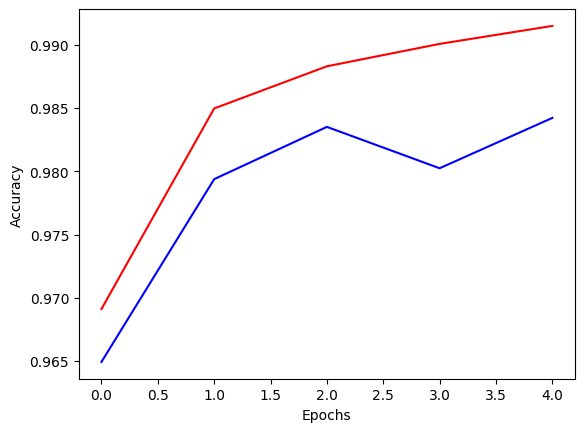

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], c='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(history.history['val_accuracy'], c='blue')
plt.show()

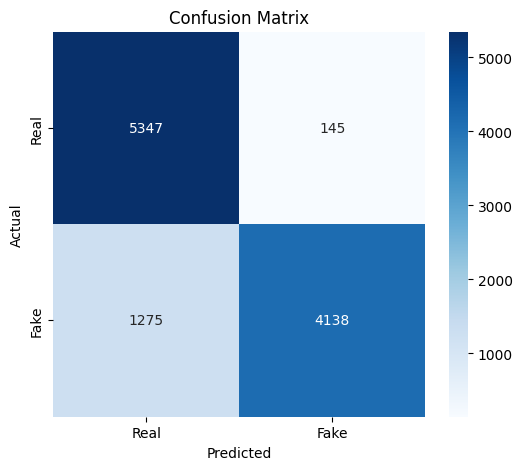


Classification Report:

              precision    recall  f1-score   support

        Real       0.81      0.97      0.88      5492
        Fake       0.97      0.76      0.85      5413

    accuracy                           0.87     10905
   macro avg       0.89      0.87      0.87     10905
weighted avg       0.89      0.87      0.87     10905



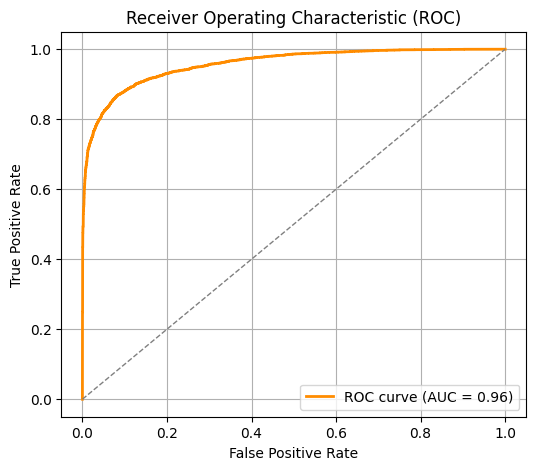


🔍 Additional Evaluation Metrics:
Accuracy     : 0.8698
Precision    : 0.9661
Recall       : 0.7645 (Sensitivity)
Specificity  : 0.9736
F1 Score     : 0.8535
AUC          : 0.9571
Z1 Score     : 0.7381 (Youden's J statistic)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, auc, accuracy_score, precision_score,
                             recall_score, f1_score)

import seaborn as sns
import tensorflow as tf

# Load model
model = tf.keras.models.load_model('/content/best_model.keras')

# Get true labels and predictions
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0).flatten()
    y_pred_probs.extend(preds)
    y_true.extend(labels.numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred = (y_pred_probs >= 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels_list = ['Real', 'Fake']
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_list, yticklabels=labels_list)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels_list))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Detailed Evaluation Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Specificity
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

# Z1 Score (Youden's J)
z1 = recall + specificity - 1

# Output additional metrics
print(f"\n🔍 Additional Evaluation Metrics:")
print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f} (Sensitivity)")
print(f"Specificity  : {specificity:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"AUC          : {roc_auc:.4f}")
print(f"Z1 Score     : {z1:.4f} (Youden's J statistic)")


In [ ]:
from tensorflow import keras
import numpy as np

# SOLUTION: Load the new, correct model you just trained
model = keras.models.load_model(
    r"/content/best_model.keras",  # <-- This is the fix
    compile=False
)

model.summary()

x = np.random.rand(1, 225, 225, 3).astype("float32")

# Predict
y = model.predict(x)

print("Input shape:", x.shape)
print("Output shape:", y.shape)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit

 Total params: 4,090,724 (15.60 MB)

 Trainable params: 3,881,437 (14.81 MB)

 Non-trainable params: 209,287 (817.53 KB)

ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(1, 225, 225, 3)

## META & EXIF USING ML

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mdappelmahmudpranto/meta-and-exif-data-original-and-manipulated-images")

print("Path to dataset files:", path)

100%|██████████| 44.1M/44.1M [00:00<00:00, 60.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mdappelmahmudpranto/meta-and-exif-data-original-and-manipulated-images/versions/1


In [ ]:
import os
os.listdir('/root/.cache/kagglehub/datasets/mdappelmahmudpranto/meta-and-exif-data-original-and-manipulated-images/versions/1')

['manipulated_unmanipulated.csv']

In [ ]:
! mv /root/.cache/kagglehub/datasets/mdappelmahmudpranto/meta-and-exif-data-original-and-manipulated-images/versions/1/* /content/

In [ ]:
# STEP 1: Setup & Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# If using Google Drive:
# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_csv('/content/drive/MyDrive/your_dataset.csv')

# Load your metadata CSV (replace with your actual filename)
df = pd.read_csv('/content/manipulated_unmanipulated.csv')

# STEP 2: Quick Overview
print("Shape of dataset:", df.shape)
print("\nSample Data:")
display(df.head())

Shape of dataset: (15143, 3)

Sample Data:


metadata  \
0  {'ResolutionUnit': 2, 'ExifOffset': 224, 'Make...   
1  {'ResolutionUnit': 2, 'ExifOffset': 224, 'Make...   
2  {'CustomRendered': 0, 'ExposureMode': 1, 'Whit...   
3  {'CustomRendered': 0, 'ExposureMode': 1, 'Whit...   
4  {'ResolutionUnit': 2, 'ExifOffset': 224, 'Make...   

                                           exif_data  manipulation  
0  {296: 2, 34665: 224, 271: 'Canon', 272: 'Canon...          True  
1  {296: 2, 34665: 224, 271: 'Canon', 272: 'Canon...          True  
2  {41985: 0, 41986: 1, 41987: 1, 41990: 0, 296: ...          True  
3  {41985: 0, 41986: 1, 41987: 1, 41988: 0.0, 419...          True  
4  {296: 2, 34665: 224, 271: 'Canon', 272: 'Canon...          True

In [ ]:
import pandas as pd
import ast
import re

# STEP 1: Preprocess malformed strings (clean up b'' and \x artifacts)
def clean_dict_string(s):
    if isinstance(s, str):
        # Replace byte strings like b'...' with just '...'
        s = re.sub(r"b'(.*?)'", r"'\1'", s)
        # Remove backslash-x hex codes which might break parsing
        s = re.sub(r'\\\\x[0-9a-fA-F]{2}', '', s)
    return s

# STEP 2: Safe parsing using ast.literal_eval
def safe_literal_eval(s):
    try:
        return ast.literal_eval(s)
    except (ValueError, SyntaxError):
        return {}

# STEP 3: Apply cleanup + parsing
df['metadata'] = df['metadata'].apply(clean_dict_string).apply(safe_literal_eval)
df['exif_data'] = df['exif_data'].apply(clean_dict_string).apply(safe_literal_eval)

# STEP 4: Merge both dictionaries into one
def merge_dicts(row):
    merged = {}
    if isinstance(row['metadata'], dict):
        merged.update(row['metadata'])
    if isinstance(row['exif_data'], dict):
        merged.update(row['exif_data'])
    return merged

df['merged_meta'] = df.apply(merge_dicts, axis=1)

# Quick check
print("✅ Parsed & Merged Example:")
print(df['merged_meta'].iloc[0])


✅ Parsed & Merged Example:
{'ResolutionUnit': 2, 'ExifOffset': 224, 'Make': 'Canon', 'Model': 'Canon EOS DIGITAL REBEL XSi', 'Software': 'Adobe Photoshop 7.0', 'Orientation': 1, 'DateTime': '2010:03:21 14:26:35', 'YCbCrPositioning': 2, 'XResolution': 72.0, 'YResolution': 72.0, 'ExifVersion': '0221', 'ComponentsConfiguration': '\x01\x02\x03\x00', 'ShutterSpeedValue': 3.625, 'DateTimeOriginal': '2010:03:21 14:11:05', 'DateTimeDigitized': '2010:03:21 14:11:05', 'ApertureValue': 4.0, 'ExposureBiasValue': 0.0, 'MeteringMode': 3, 'UserComment': '\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

In [ ]:
# Expand merged_meta into separate columns
meta_df = pd.json_normalize(df['merged_meta'])
print("📊 Flattened shape:", meta_df.shape)

# Combine back with original
df_expanded = pd.concat([df.drop(columns=['metadata', 'exif_data', 'merged_meta']), meta_df], axis=1)

📊 Flattened shape: (15143, 361)


In [ ]:
def safe_to_str(val):
    """Safely convert to string, even if it's a bytes object."""
    try:
        if isinstance(val, bytes):
            return val.decode('utf-8', errors='ignore')
        return str(val)
    except Exception:
        return ''

def is_garbage_column(col):
    # Apply safe conversion to each element
    str_col = col.map(safe_to_str)
    return str_col.str.fullmatch(r'[\x00\\x00]*').mean() > 0.9 or col.isna().mean() > 0.9

# Now filter junk columns
drop_cols = [col for col in meta_df.columns if is_garbage_column(meta_df[col])]
df_expanded.drop(columns=drop_cols, inplace=True)
print("🧹 Dropped junk columns:", drop_cols)


🧹 Dropped junk columns: ['GainControl', 'SubjectLocation', 'PrintImageMatching', 'BrightnessValue', 41991, 37396, 50341, 37379, 'CFAPattern', 'BodySerialNumber', 'LensSpecification', 'LensModel', 41730, 42033, 42034, 42036, 50898, 50899, 'ImageWidth', 'ImageLength', 'ProcessingSoftware', 256, 257, 11, 'GPSInfo.5', 'GPSInfo.6', 'GPSInfo.18', '34853.5', '34853.6', '34853.18', 'CameraOwnerName', 42032, 59932, 'GPSInfo.10', 'GPSInfo.11', 'GPSInfo.59932', '34853.10', '34853.11', '34853.59932', 'RecommendedExposureIndex', 34866, 'LensMake', 42035, 'GPSInfo.7', 'GPSInfo.12', 'GPSInfo.13', 'GPSInfo.16', 'GPSInfo.17', 'GPSInfo.23', 'GPSInfo.24', 'GPSInfo.29', 'GPSInfo.31', '34853.7', '34853.12', '34853.13', '34853.16', '34853.17', '34853.23', '34853.24', '34853.29', '34853.31', 59933, 'XPKeywords', 40094, 'Gamma', 42240, 'ImageUniqueID', 42016, 'GPSInfo.8', '34853.8', 'HostComputer', 316, 'BitsPerSample', 'PhotometricInterpretation', 'SamplesPerPixel', 258, 262, 277, 'LensSerialNumber', 42037, 

In [ ]:
# List all datetime-related columns
datetime_cols = ['DateTime', 'DateTimeOriginal', 'DateTimeDigitized']

for col in datetime_cols:
    if col in df_expanded.columns:
        # Force datetime parsing
        df_expanded[col] = pd.to_datetime(df_expanded[col], errors='coerce')

        # Remove timezone if present
        df_expanded[col] = df_expanded[col].dt.tz_localize(None)


In [ ]:
if {'DateTime', 'DateTimeOriginal'}.issubset(df_expanded.columns):
    df_expanded['TimeGap'] = (df_expanded['DateTime'] - df_expanded['DateTimeOriginal']).dt.total_seconds()


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode common categorical fields
categorical_cols = ['Make', 'Model', 'Software', 'WhiteBalance', 'ExposureProgram', 'CustomRendered']
label_encoders = {}

for col in categorical_cols:
    if col in df_expanded.columns:
        df_expanded[col] = df_expanded[col].astype(str).fillna('Unknown')
        le = LabelEncoder()
        df_expanded[col] = le.fit_transform(df_expanded[col])
        label_encoders[col] = le

In [ ]:
# Drop numeric tag columns (like 33434, 37385 etc.)
numeric_tag_cols = [col for col in df_expanded.columns if isinstance(col, int) or (str(col).isdigit() and int(col) > 255)]
df_expanded.drop(columns=numeric_tag_cols, inplace=True)

In [ ]:
X = df_expanded.drop(columns=['manipulation'])  # Features
y = df_expanded['manipulation'].astype(int)     # Target

print("✅ Final matrix shape:", X.shape)

✅ Final matrix shape: (15143, 68)


In [ ]:
from sklearn.impute import SimpleImputer

# # Separate target
# X = df_expanded.drop(columns=['manipulation'])  # adjust if needed
# y = df_expanded['manipulation'].astype(int)

# # def detect_datetime_in_object_cols(df):
# #     datetime_like_cols = []
# #     for col in df.select_dtypes(include='object').columns:
# #         try:
# #             parsed = pd.to_datetime(df[col], errors='raise')
# #             if parsed.dt.tz is not None or parsed.dt.tz_localize(None) is not None:
# #                 datetime_like_cols.append(col)
# #         except Exception:
# #             pass  # Not datetime
# #     return datetime_like_cols

# # problematic_cols = detect_datetime_in_object_cols(X)
# # print("Datetime-like object columns:", problematic_cols)



# # Check for datetime columns
# datetime_cols = X.select_dtypes(include=['datetime64[ns]', 'datetimetz']).columns
# print(datetime_cols)

# for col in datetime_cols:
#     X[col] = X[col].astype(str)

# # Separate numeric and categorical
# numeric_cols = X.select_dtypes(include='number').columns
# categorical_cols = X.select_dtypes(include='object').columns

# for col in categorical_cols:
#     try:
#         X[[col]] = cat_imputer.fit_transform(X[[col]])
#     except Exception as e:
#         print(f"❌ Error in column: {col} — {e}")


# # # Imputers
# # num_imputer = SimpleImputer(strategy='median')  # or 'mean'
# # cat_imputer = SimpleImputer(strategy='most_frequent')

# # X[numeric_cols] = num_imputer.fit_transform(X[numeric_cols])
# # X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])

# Optionally convert to string before imputation
for col in datetime_cols:
    if col in df_expanded.columns:
        df_expanded[col] = df_expanded[col].astype(str)

X = df_expanded.drop(columns=['manipulation'])
y = df_expanded['manipulation'].astype(int)

numeric_cols = X.select_dtypes(include='number').columns
categorical_cols = X.select_dtypes(include='object').columns

X[numeric_cols] = SimpleImputer(strategy='median').fit_transform(X[numeric_cols])
X[categorical_cols] = SimpleImputer(strategy='most_frequent').fit_transform(X[categorical_cols])


In [ ]:
sparsity = X.isna().mean()
sparse_cols = sparsity[sparsity > 0.9].index.tolist()  # 90%+ missing
temp = X.drop(columns=sparse_cols)
temp

ResolutionUnit  ExifOffset  Make  Model  Software  Orientation  \
0                 2.0       224.0   5.0   85.0      55.0          1.0   
1                 2.0       224.0   5.0   85.0      55.0          1.0   
2                 2.0       272.0   5.0   85.0      55.0          1.0   
3                 2.0       462.0  21.0  232.0     196.0          1.0   
4                 2.0       224.0   5.0   85.0      55.0          1.0   
...               ...         ...   ...    ...       ...          ...   
15138             2.0        26.0  66.0  458.0     392.0          1.0   
15139             2.0        38.0  66.0  458.0     392.0          1.0   
15140             2.0        26.0  66.0  458.0     392.0          1.0   
15141             2.0        26.0  66.0  458.0     392.0          1.0   
15142             2.0        38.0  66.0  458.0     392.0          1.0   

      DateTime  YCbCrPositioning  XResolution  YResolution  ...  \
0          NaT               2.0         72.0         72.0  ...   
1          NaT               2.0         72.0         72.0  ...   
2          NaT               2.0         72.0         72.0  ...   
3          NaT               2.0         72.0         72.0  ...   
4          NaT               2.0         72.0         72.0  ...   
...        ...               ...          ...          ...  ...   
15138      NaT               2.0         72.0         72.0  ...   
15139      NaT               2.0         72.0         72.0  ...   
15140      NaT               2.0         72.0         72.0  ...   
15141      NaT               2.0         72.0         72.0  ...   
15142      NaT               2.0         72.0         72.0  ...   

                GPSInfo.2 GPSInfo.3            GPSInfo.4 34853.0 34853.1  \
0      (6.0, 54.0, 24.41)         W  (79.0, 51.0, 38.42)             N   
1      (6.0, 54.0, 24.41)         W  (79.0, 51.0, 38.42)             N   
2      (6.0, 54.0, 24.41)         W  (79.0, 51.0, 38.42)             N   
3      (6.0, 54.0, 24.41)         W  (79.0, 51.0, 38.42)             N   
4      (6.0, 54.0, 24.41)         W  (79.0, 51.0, 38.42)             N   
...                   ...       ...                  ...     ...     ...   
15138  (6.0, 54.0, 24.41)         W  (79.0, 51.0, 38.42)             N   
15139  (6.0, 54.0, 24.41)         W  (79.0, 51.0, 38.42)             N   
15140  (6.0, 54.0, 24.41)         W  (79.0, 51.0, 38.42)             N   
15141  (6.0, 54.0, 24.41)         W  (79.0, 51.0, 38.42)             N   
15142  (6.0, 54.0, 24.41)         W  (79.0, 51.0, 38.42)             N   

                  34853.2  34853.3              34853.4 Copyright  TimeGap  
0      (6.0, 54.0, 24.41)        W  (79.0, 51.0, 38.42)            90427.0  
1      (6.0, 54.0, 24.41)        W  (79.0, 51.0, 38.42)            90427.0  
2      (6.0, 54.0, 24.41)        W  (79.0, 51.0, 38.42)            90427.0  
3      (6.0, 54.0, 24.41)        W  (79.0, 51.0, 38.42)            90427.0  
4      (6.0, 54.0, 24.41)        W  (79.0, 51.0, 38.42)            90427.0  
...                   ...      ...                  ...       ...      ...  
15138  (6.0, 54.0, 24.41)        W  (79.0, 51.0, 38.42)            90427.0  
15139  (6.0, 54.0, 24.41)        W  (79.0, 51.0, 38.42)            90427.0  
15140  (6.0, 54.0, 24.41)        W  (79.0, 51.0, 38.42)            90427.0  
15141  (6.0, 54.0, 24.41)        W  (79.0, 51.0, 38.42)            90427.0  
15142  (6.0, 54.0, 24.41)        W  (79.0, 51.0, 38.42)            90427.0  

[15143 rows x 68 columns]

In [ ]:
X = temp

In [ ]:

import string

def is_garbage_string(s, threshold=0.9):
    """Return True if the string s contains mostly non-printable chars."""
    if not isinstance(s, str):
        return False
    printable_chars = set(string.printable)
    non_printable_ratio = sum(c not in printable_chars for c in s) / max(len(s), 1)
    return non_printable_ratio > threshold

def find_garbage_cols(df, threshold=0.9):
    garbage_cols = []
    for col in df.columns:
        if df[col].dtype == object:
            # Check the proportion of garbage strings
            garbage_ratio = df[col].dropna().apply(is_garbage_string).mean()
            if garbage_ratio > threshold:
                garbage_cols.append(col)
    return garbage_cols

garbage_cols = find_garbage_cols(X)
print("Garbage-like columns:", garbage_cols)


Garbage-like columns: ['ComponentsConfiguration', 'UserComment', 'FileSource', 'SceneType', 'GPSInfo.0', '34853.0']


In [ ]:
X = X.drop(columns=garbage_cols)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15143 entries, 0 to 15142
Data columns (total 62 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ResolutionUnit              15143 non-null  float64
 1   ExifOffset                  15143 non-null  float64
 2   Make                        15143 non-null  float64
 3   Model                       15143 non-null  float64
 4   Software                    15143 non-null  float64
 5   Orientation                 15143 non-null  float64
 6   DateTime                    15143 non-null  object 
 7   YCbCrPositioning            15143 non-null  float64
 8   XResolution                 15143 non-null  float64
 9   YResolution                 15143 non-null  float64
 10  ExifVersion                 15143 non-null  object 
 11  ShutterSpeedValue           15143 non-null  float64
 12  DateTimeOriginal            15143 non-null  object 
 13  DateTimeDigitized           151

In [ ]:
X = X.drop("TimeGap", axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 4.9 MB/s eta 0:00:00


In [ ]:
# Try decoding object columns to UTF-8 and catch any decode errors
def has_non_utf8(col):
    try:
        col.astype(str).apply(lambda x: x.encode('utf-8').decode('utf-8'))
        return False
    except UnicodeDecodeError:
        return True

bad_text_cols = [col for col in X.select_dtypes(include='object').columns if has_non_utf8(X[col])]
print("🚨 Non-UTF8 columns:", bad_text_cols)

🚨 Non-UTF8 columns: ['MakerNote']


In [ ]:
X = X.drop(columns=bad_text_cols)
X_train = X_train.drop(columns=bad_text_cols)
X_test = X_test.drop(columns=bad_text_cols)

In [ ]:
import category_encoders as ce

encoder = ce.CatBoostEncoder(cols=X.select_dtypes(include='object').columns)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

In [ ]:
!pip install lightgbm

In [ ]:
import lightgbm as lgb
from sklearn.metrics import classification_report, roc_auc_score

model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train_encoded, y_train)

[LightGBM] [Info] Number of positive: 5224, number of negative: 6890
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8125
[LightGBM] [Info] Number of data points in the train set: 12114, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431237 -> initscore=-0.276808
[LightGBM] [Info] Start training from score -0.276808


LGBMClassifier(random_state=42)

In [ ]:
y_pred = model.predict(X_test_encoded)
y_proba = model.predict_proba(X_test_encoded)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.90      1.00      0.94      1723
           1       1.00      0.85      0.92      1306

    accuracy                           0.93      3029
   macro avg       0.95      0.92      0.93      3029
weighted avg       0.94      0.93      0.93      3029

ROC AUC: 0.9803598552686428


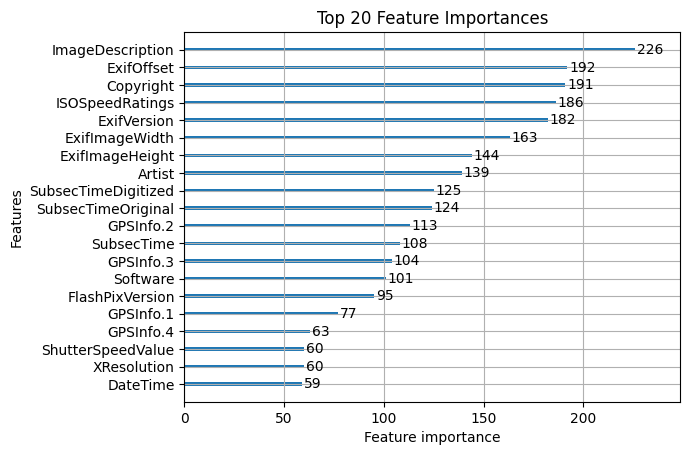

In [ ]:
import matplotlib.pyplot as plt

lgb.plot_importance(model, max_num_features=20)
plt.title("Top 20 Feature Importances")
plt.show()


In [ ]:
import joblib

joblib.dump(model, 'lgbm_model.joblib')

['lgbm_model.joblib']

In [ ]:
! pip show numpy

Name: numpy
Version: 2.0.2
Summary: Fundamental package for array computing in Python
Home-page: https://numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: Copyright (c) 2005-2024, NumPy Developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are
met:

    * Redistributions of source code must retain the above copyright
       notice, this list of conditions and the following disclaimer.

    * Redistributions in binary form must reproduce the above
       copyright notice, this list of conditions and the following
       disclaimer in the documentation and/or other materials provided
       with the distribution.

    * Neither the name of the NumPy Developers nor the names of any
       contributors may be used to endorse or promote products derived
       from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRI

In [ ]:
! pip install xgboost

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train_encoded, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred = model.predict(X_test_encoded)
y_proba = model.predict_proba(X_test_encoded)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.90      1.00      0.94      1723
           1       1.00      0.85      0.92      1306

    accuracy                           0.93      3029
   macro avg       0.95      0.92      0.93      3029
weighted avg       0.94      0.93      0.93      3029

ROC AUC: 0.980156321242464


📊 Classification Report:
              precision    recall  f1-score   support

           0     0.8958    0.9983    0.9443      1723
           1     0.9973    0.8469    0.9159      1306

    accuracy                         0.9330      3029
   macro avg     0.9466    0.9226    0.9301      3029
weighted avg     0.9396    0.9330    0.9321      3029

✅ Accuracy: 0.9329811819082205
✅ Precision: 0.9972948602344455
✅ Recall: 0.8468606431852986
✅ F1 Score: 0.9159420289855073
✅ ROC AUC: 0.980156321242464
✅ Average Precision (PR AUC): 0.96186032321879
✅ Cohen's Kappa: 0.8608326183191058
✅ Matthews Correlation Coefficient: 0.868792292236251
✅ Log Loss: 0.14254013649819255
✅ Brier Score Loss: 0.048915468035259466


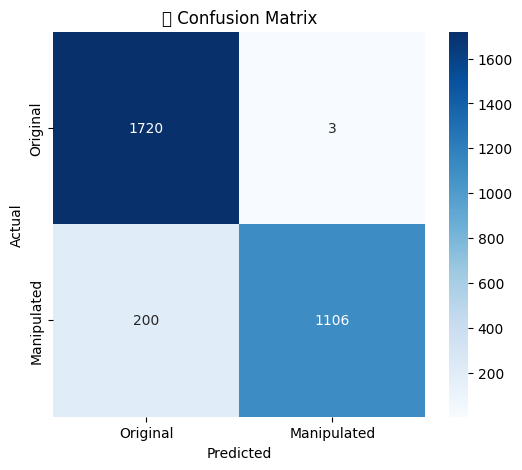

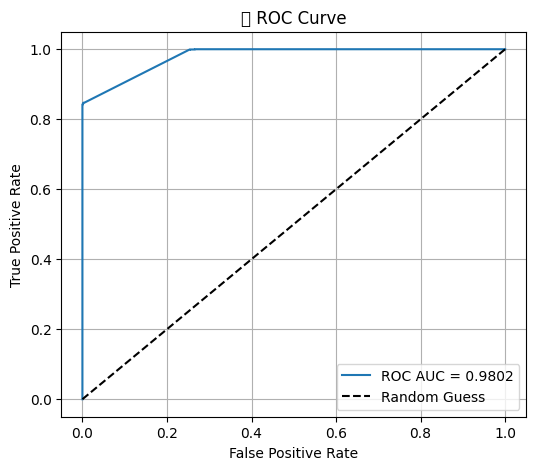

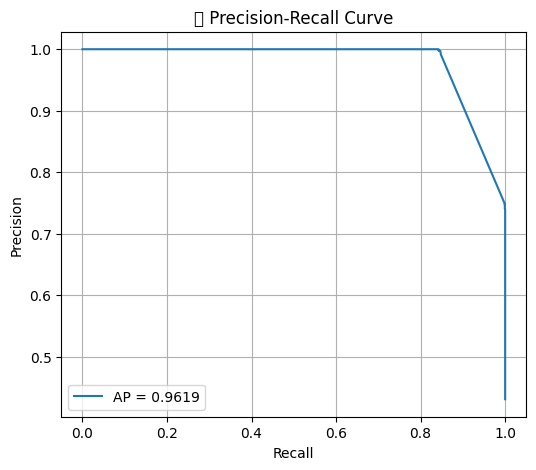

In [ ]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    cohen_kappa_score,
    matthews_corrcoef,
    log_loss,
    brier_score_loss
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Basic Predictions
y_pred = model.predict(X_test_encoded)
y_proba = model.predict_proba(X_test_encoded)[:, 1]  # Probabilities for positive class

# 2. Core Metrics
print("📊 Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("✅ Precision:", precision_score(y_test, y_pred))
print("✅ Recall:", recall_score(y_test, y_pred))
print("✅ F1 Score:", f1_score(y_test, y_pred))
print("✅ ROC AUC:", roc_auc_score(y_test, y_proba))
print("✅ Average Precision (PR AUC):", average_precision_score(y_test, y_proba))
print("✅ Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))
print("✅ Matthews Correlation Coefficient:", matthews_corrcoef(y_test, y_pred))
print("✅ Log Loss:", log_loss(y_test, y_proba))
print("✅ Brier Score Loss:", brier_score_loss(y_test, y_proba))

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Manipulated'], yticklabels=['Original', 'Manipulated'])
plt.title("🧩 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 4. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_proba):.4f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("🔥 ROC Curve")
plt.legend()
plt.grid()
plt.show()

# 5. Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(rec, prec, label=f"AP = {average_precision_score(y_test, y_proba):.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("🎯 Precision-Recall Curve")
plt.grid()
plt.legend()
plt.show()


## CASIA DS: GOOGLE ViT BASE MODEL PATCH 16 224: 80%

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("divg07/casia-20-image-tampering-detection-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/casia-20-image-tampering-detection-dataset


In [ ]:
! mv /kaggle/input/casia-20-image-tampering-detection-dataset/* /content

Streaming output truncated to the last 5000 lines.
mv: cannot remove '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp/Tp_S_NNN_S_N_ani00086_ani00086_11125.jpg': Read-only file system
mv: cannot remove '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp/Tp_S_NNN_S_N_art00017_art00017_00920.tif': Read-only file system
mv: cannot remove '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp/Tp_S_NND_S_N_ani00072_ani00072_00192.tif': Read-only file system
mv: cannot remove '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp/Tp_S_NNN_S_N_sec00024_sec00024_00747.tif': Read-only file system
mv: cannot remove '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp/Tp_S_NNN_S_N_arc20091_arc20091_01731.tif': Read-only file system
mv: cannot remove '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp/Tp_D_NNN_S_N_nat00007_ani00021_00627.tif': Read-only file system
mv: cannot remove '/kaggle/input/casia-20-i

In [ ]:
! rm -r /content/CASIA2/CASIA\ 2\ Groundtruth

In [ ]:
import os

len(os.listdir('/content/CASIA2/Tp'))

5125

In [ ]:
import os

for i in os.listdir('/content/CASIA2/Tp'):
  if i.split('.')[1] == 'db':
    print("deleted")
    os.remove(os.path.join('/content/CASIA2/Tp', i))

deleted


In [ ]:
import os

for i in os.listdir('/content/CASIA2/Au'):
  if i.split('.')[1] == 'db':
    print("deleted")
    os.remove(os.path.join('/content/CASIA2/Au', i))

deleted


In [ ]:
import numpy as np

Tampered = os.listdir('/content/CASIA2/Tp')
Authentic = os.listdir('/content/CASIA2/Au')[:len(Tampered)]

new_Tampered = []
new_authentic = []

for i in Tampered:
  if i.split('.')[1] == 'txt':
    continue

  new_Tampered.append('/content/CASIA2/Tp/' + i)

for i in Authentic:
  if i.split('.')[1] == 'txt':
    continue

  new_authentic.append('/content/CASIA2/Au/' + i)

Tampered = new_Tampered
Authentic = new_authentic

Y = np.append(np.ones(len(Tampered)), np.zeros(len(Authentic)))

X = np.append(np.array(Tampered), np.array(Authentic))

print(f"X Shape: {X.shape}")
print(f"Y Shape: {Y.shape}")

X Shape: (10247,)
Y Shape: (10247,)


In [ ]:
from collections import defaultdict

cnt = defaultdict(int)

for i in X:
  cnt[i.split('.')[1]] += 1

cnt

defaultdict(int, {'tif': 3059, 'jpg': 7157, 'bmp': 31})

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=69)

print(f"X Train Shape: {x_train.shape}")
print(f"Y Train Shape: {y_train.shape}")
print(f"X Test Shape: {x_test.shape}")
print(f"Y Test Shape: {y_test.shape}")

X Train Shape: (8197,)
Y Train Shape: (8197,)
X Test Shape: (2050,)
Y Test Shape: (2050,)


In [ ]:
! pip install transformers torchvision datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import torch

from torchvision import transforms
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
])


class CasiaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        """
        Args:
            image_paths (List[str]): Paths to image files
            labels (List[int]): 0 for authentic, 1 for tampered
            transform (callable, optional): Optional image transform
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label

from torch.utils.data import DataLoader

train_dataset = CasiaDataset(image_paths=x_train, labels=y_train, transform=train_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

test_dataset = CasiaDataset(image_paths=x_test, labels=y_test, transform=val_transforms)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import AutoImageProcessor, AutoModelForImageClassification
from tqdm import tqdm
import torch.nn as nn
from torch.optim import AdamW

model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")

model.classifier = nn.Linear(model.classifier.in_features, 2)

model.to("cuda" if torch.cuda.is_available() else "cpu")

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)


In [ ]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0
    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)


In [ ]:
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    return total_loss / len(dataloader), accuracy


In [ ]:
num_epochs = 5
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_acc = evaluate(model, test_loader, loss_fn, device)
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/5


Training:   0%|          | 0/257 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating: 100%|██████████| 65/65 [00:25<00:00,  2.52it/s]


Train Loss: 0.5095 | Val Loss: 0.4312 | Val Acc: 0.8068

Epoch 2/5


Evaluating: 100%|██████████| 65/65 [00:25<00:00,  2.56it/s]


Train Loss: 0.3554 | Val Loss: 0.4544 | Val Acc: 0.7883

Epoch 3/5


Evaluating: 100%|██████████| 65/65 [00:25<00:00,  2.52it/s]


Train Loss: 0.2825 | Val Loss: 0.4538 | Val Acc: 0.8278

Epoch 4/5


Evaluating: 100%|██████████| 65/65 [00:25<00:00,  2.52it/s]


Train Loss: 0.2675 | Val Loss: 0.5248 | Val Acc: 0.7829

Epoch 5/5


Evaluating: 100%|██████████| 65/65 [00:25<00:00,  2.53it/s]

Train Loss: 0.2308 | Val Loss: 0.5491 | Val Acc: 0.7732


In [ ]:
torch.save(model, "vit_casia_full_model_bin.pt")

In [ ]:
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)[:, 1]  # probability of class 1
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    return total_loss / len(dataloader), accuracy, all_preds, all_labels, all_probs


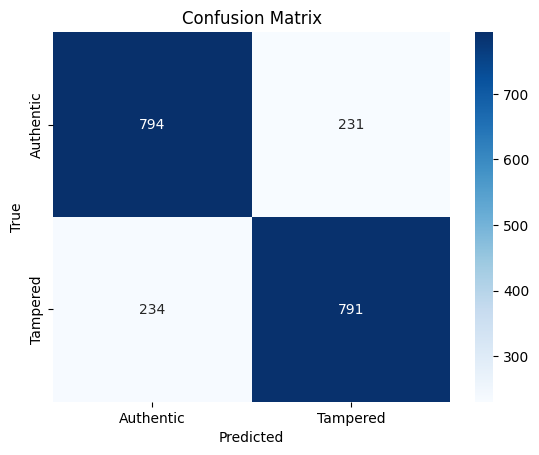

Classification Report:

              precision    recall  f1-score   support

   Authentic       0.77      0.77      0.77      1025
    Tampered       0.77      0.77      0.77      1025

    accuracy                           0.77      2050
   macro avg       0.77      0.77      0.77      2050
weighted avg       0.77      0.77      0.77      2050


Additional Evaluation Metrics:
Accuracy   : 0.7732
Precision  : 0.7740
Recall     : 0.7717
Specificity: 0.7746
F1 Score   : 0.7728
AUC        : 0.8551
Z1 Score   : 0.7737


In [ ]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Evaluate the model
val_loss, val_acc, preds, labels, probs = evaluate(model, test_loader, loss_fn, device)

# Confusion Matrix
cm = confusion_matrix(labels, preds)
tn, fp, fn, tp = cm.ravel()

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Authentic", "Tampered"],
            yticklabels=["Authentic", "Tampered"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(labels, preds, target_names=["Authentic", "Tampered"]))

# Metrics Calculation
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
f1 = f1_score(labels, preds)

# ROC AUC
try:
    auc = roc_auc_score(labels, probs)
except ValueError:
    auc = None
    print("ROC AUC cannot be computed (check label variety).")

# Z1 Score (You can define it differently; here’s one example based on F1 and Specificity)
z1_score = (2 * f1 * specificity) / (f1 + specificity) if (f1 + specificity) != 0 else 0

# Display Metrics
print("\nAdditional Evaluation Metrics:")
print(f"Accuracy   : {accuracy:.4f}")
print(f"Precision  : {precision:.4f}")
print(f"Recall     : {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score   : {f1:.4f}")
print(f"AUC        : {auc:.4f}" if auc is not None else "AUC        : N/A")
print(f"Z1 Score   : {z1_score:.4f}")


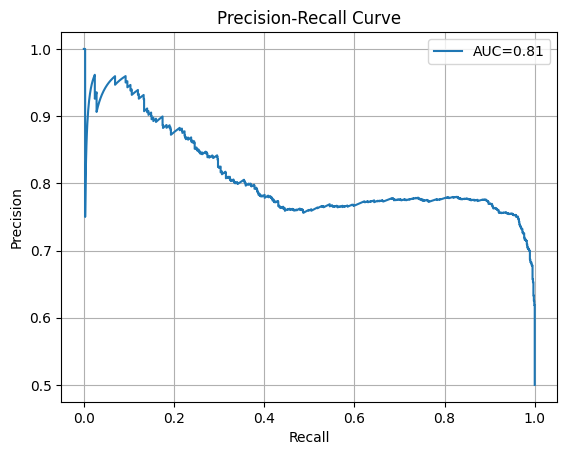

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, _ = precision_recall_curve(labels, probs)
pr_auc = auc(recall, precision)

plt.plot(recall, precision, label=f"AUC={pr_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


## Google ViT: JPEG Compression DS: 85%+

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("liuqzsc/seam-carving-jpeg-image-forgery-dataset")

print("Path to dataset files:", path)

In [ ]:
! mv /kaggle/input/seam-carving-jpeg-image-forgery-dataset/seamcarving_kaggle/seamcarving_kaggle/Q75 /content/

In [ ]:
from collections import defaultdict
import os

cnt = defaultdict(int)

for i in os.listdir('/content/Dataset/untouched'):
  cnt[i.split('.')[1]] += 1

cnt

In [ ]:
import numpy as np

Tampered = os.listdir('/content/Dataset/seam_carving')
Authentic = os.listdir('/content/Dataset/untouched')

new_Tampered = []
new_authentic = []

for i in Tampered:
  if i.split('.')[1] == 'txt':
    continue

  new_Tampered.append('/content/Dataset/seam_carving/' + i)

for i in Authentic:
  if i.split('.')[1] == 'txt':
    continue

  new_authentic.append('/content/Dataset/untouched/' + i)

Tampered = new_Tampered
Authentic = new_authentic

Y = np.append(np.ones(len(Tampered)), np.zeros(len(Authentic)))

X = np.append(np.array(Tampered), np.array(Authentic))

print(f"X Shape: {X.shape}")
print(f"Y Shape: {Y.shape}")

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=69)

print(f"X Train Shape: {x_train.shape}")
print(f"Y Train Shape: {y_train.shape}")
print(f"X Test Shape: {x_test.shape}")
print(f"Y Test Shape: {y_test.shape}")

In [ ]:
! pip install transformers torchvision datasets

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import torch

from torchvision import transforms
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
])


class CasiaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        """
        Args:
            image_paths (List[str]): Paths to image files
            labels (List[int]): 0 for authentic, 1 for tampered
            transform (callable, optional): Optional image transform
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label

from torch.utils.data import DataLoader

train_dataset = CasiaDataset(image_paths=x_train, labels=y_train, transform=train_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

test_dataset = CasiaDataset(image_paths=x_test, labels=y_test, transform=val_transforms)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import AutoImageProcessor, AutoModelForImageClassification
from tqdm import tqdm
import torch.nn as nn
from torch.optim import AdamW

model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")
model.classifier = nn.Linear(model.classifier.in_features, 2)
model.to("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0
    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)


In [ ]:
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    return total_loss / len(dataloader), accuracy


In [ ]:
num_epochs = 5
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_acc = evaluate(model, test_loader, loss_fn, device)
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

In [ ]:
torch.save(model, "vit_jpegComp_88_full_model_bin.pt")

In [ ]:
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)[:, 1]  # probability of class 1
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    return total_loss / len(dataloader), accuracy, all_preds, all_labels, all_probs


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

val_loss, val_acc, preds, labels, probs = evaluate(model, test_loader, loss_fn, device)

# Confusion matrix
cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Authentic", "Tampered"], yticklabels=["Authentic", "Tampered"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(labels, preds, target_names=["Authentic", "Tampered"]))

# ROC AUC Score
try:
    auc = roc_auc_score(labels, probs)
    print(f"ROC AUC Score: {auc:.4f}")
except ValueError:
    print("ROC AUC cannot be computed (check label variety).")


In [ ]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, _ = precision_recall_curve(labels, probs)
pr_auc = auc(recall, precision)

plt.plot(recall, precision, label=f"AUC={pr_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


## Loading Directly

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("duyminhle/inpainting-localization-eval-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.19G/1.19G [00:16<00:00, 75.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/duyminhle/inpainting-localization-eval-dataset/versions/1


In [ ]:
import os

os.listdir(path)

['CA', 'GC', 'LB', 'TE', 'README.md', 'RN', 'SG', 'LR', 'SH', 'NS', 'EC', 'PM']

In [ ]:
! mv /root/.cache/kagglehub/datasets/duyminhle/inpainting-localization-eval-dataset/versions/1/* /content

In [ ]:
import os
from collections import defaultdict
import shutil as shit

cnt = defaultdict(int)

for i in os.listdir('/content'):
  if len(i) == 2:
    # print(i)
    for j in os.listdir(os.path.join('/content', i)):
      try:
        cnt[j.split('.')[1]] += 1
        shit.copy(os.path.join('/content', i, j), '/content/Dataset/' + j)

      except Exception as e:
        pass

print(cnt)

defaultdict(<class 'int'>, {'png': 22000})


In [ ]:
! mkdir /content/Dataset

In [ ]:
import os

len(os.listdir('/content/Dataset'))

20000

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("divg07/casia-20-image-tampering-detection-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.56G/2.56G [00:29<00:00, 92.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/divg07/casia-20-image-tampering-detection-dataset/versions/1


In [ ]:
! mv /root/.cache/kagglehub/datasets/divg07/casia-20-image-tampering-detection-dataset/versions/1/* /content

In [ ]:
! mkdir /content/New\ Dataset

In [ ]:
import os

print(f"Authentic: {len(os.listdir('/content/New Dataset/Au'))}")
print(f"Tampered: {len(os.listdir('/content/New Dataset/Inpainting'))}")

Authentic: 7492
Tampered: 7492


In [ ]:
! rm -r /content/New\ Dataset

In [ ]:
import os
from collections import defaultdict
import shutil as shit

cnt = defaultdict(int)

for i in os.listdir('/content/Temp')[:len(os.listdir('/content/New Dataset/Au'))]:
  try:
    cnt[i.split('.')[1]] += 1
    shit.copy(os.path.join('/content/Temp', i), '/content/New Dataset/Inpainting/' + i)

  except Exception as e:
    pass

print(cnt)

defaultdict(<class 'int'>, {'png': 7492})


In [ ]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.load_model('/content/Inpainting-vgg16-80.keras')

model.summary()

ValueError: File not found: filepath=/content/Inpainting-vgg16-80.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Path to your dataset
dataset_path = "Dataset"

# Load the dataset
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

test_dataset = image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='binary',  # because it's binary classification
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False  # Important: don't shuffle if you're evaluating
)


Found 27491 files belonging to 2 classes.


In [ ]:
# Apply VGG16 preprocessing
def preprocess(image, label):
    return preprocess_input(image), label

test_dataset_preprocessed = test_dataset.map(preprocess)


In [ ]:
import numpy as np
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_score, recall_score, f1_score, accuracy_score,
    average_precision_score, cohen_kappa_score, matthews_corrcoef,
    log_loss, brier_score_loss, roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels and predictions
y_true = np.concatenate([y for _, y in test_dataset_preprocessed])
y_proba = model.predict(test_dataset_preprocessed).flatten()
y_pred = (y_proba >= 0.5).astype(int)

860/860 ━━━━━━━━━━━━━━━━━━━━ 162s 173ms/step


In [ ]:
print("Classification Report:\n", classification_report(y_true, y_pred, digits=4))
print("✅ Accuracy:", accuracy_score(y_true, y_pred))
print("✅ Precision:", precision_score(y_true, y_pred))
print("✅ Recall:", recall_score(y_true, y_pred))
print("✅ F1 Score:", f1_score(y_true, y_pred))
print("✅ ROC AUC:", roc_auc_score(y_true, y_proba))
print("✅ PR AUC:", average_precision_score(y_true, y_proba))
print("✅ Cohen's Kappa:", cohen_kappa_score(y_true, y_pred))
print("✅ Matthews Corrcoef:", matthews_corrcoef(y_true, y_pred))
print("✅ Log Loss:", log_loss(y_true, y_proba))
print("✅ Brier Score Loss:", brier_score_loss(y_true, y_proba))


Classification Report:
               precision    recall  f1-score   support

         0.0     0.3732    0.9531    0.5363      7491
         1.0     0.9580    0.4003    0.5647     20000

    accuracy                         0.5509     27491
   macro avg     0.6656    0.6767    0.5505     27491
weighted avg     0.7986    0.5509    0.5569     27491

✅ Accuracy: 0.5509439452911862
✅ Precision: 0.9579992820390092
✅ Recall: 0.4003
✅ F1 Score: 0.5646577564622491
✅ ROC AUC: 0.7841723735148846
✅ PR AUC: 0.8806761778413884
✅ Cohen's Kappa: 0.2378398941343921
✅ Matthews Corrcoef: 0.342118961073981
✅ Log Loss: 6.688971897272703
✅ Brier Score Loss: 0.4455676335519504


# Inpainting: Google ViT

In [ ]:
! pip install kagglehub

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("duyminhle/inpainting-localization-eval-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.19G/1.19G [00:58<00:00, 21.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/duyminhle/inpainting-localization-eval-dataset/versions/1


In [ ]:
import os

len(os.listdir('/content/Inpainting'))

20000

In [ ]:
import shutil
import os

path = '/root/.cache/kagglehub/datasets/duyminhle/inpainting-localization-eval-dataset/versions/1'

for i in os.listdir(path):
  if len(i) == 2:
    for j in os.listdir(os.path.join(path, i)):
      shutil.copy(os.path.join(path, i, j), '/content/Inpainting/' + j)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("divg07/casia-20-image-tampering-detection-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.56G/2.56G [02:04<00:00, 22.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/divg07/casia-20-image-tampering-detection-dataset/versions/1


In [ ]:
! mv /root/.cache/kagglehub/datasets/divg07/casia-20-image-tampering-detection-dataset/versions/1/CASIA2/Au /content/

In [ ]:
from collections import defaultdict
import os

cnt = defaultdict(int)

for i in os.listdir('/content/Au'):
  cnt[i.split('.')[1]] += 1

cnt

defaultdict(int, {'bmp': 54, 'jpg': 7437})

In [ ]:
import os

for i in os.listdir('/content/Au'):
  if i.split('.')[1] == 'db':
    os.remove(os.path.join('/content/Au', i))
    print("Removed")

Removed


In [ ]:
import os

images, labels = [], []

for i in os.listdir('/content/Au'):
  images.append(os.path.join('/content/Au', i))
  labels.append(0)

inpaints = 0
for i in os.listdir('/content/Inpainting'):
  inpaints += 1
  images.append(os.path.join('/content/Inpainting', i))
  labels.append(1)

  if inpaints == 7491:
    break

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

images = np.array(images)
labels = np.array(labels)

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=69)

print(f"X Train Shape: {x_train.shape}")
print(f"Y Train Shape: {y_train.shape}")
print(f"X Test Shape: {x_test.shape}")
print(f"Y Test Shape: {y_test.shape}")

X Train Shape: (11985,)
Y Train Shape: (11985,)
X Test Shape: (2997,)
Y Test Shape: (2997,)


In [ ]:
! pip install transformers torchvision datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import torch

from torchvision import transforms
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
])


class InpaintingDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        """
        Args:
            image_paths (List[str]): Paths to image files
            labels (List[int]): 0 for authentic, 1 for tampered
            transform (callable, optional): Optional image transform
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label

from torch.utils.data import DataLoader

train_dataset = InpaintingDataset(image_paths=x_train, labels=y_train, transform=train_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

test_dataset = InpaintingDataset(image_paths=x_test, labels=y_test, transform=val_transforms)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
train_dataset[0]

(tensor([[[ 0.8196,  0.8196,  0.8196,  ...,  0.0431,  0.0431,  0.0353],
          [ 0.8510,  0.8510,  0.8510,  ...,  0.0667,  0.0588,  0.0588],
          [ 0.8824,  0.8824,  0.8824,  ...,  0.0745,  0.0745,  0.0745],
          ...,
          [-0.0588,  0.1137,  0.1529,  ...,  0.0824, -0.0353,  0.0039],
          [-0.4353, -0.3490, -0.3176,  ...,  0.2471,  0.1216, -0.0667],
          [-0.4353, -0.2941, -0.1765,  ...,  0.1216,  0.0510,  0.0275]],
 
         [[ 0.8275,  0.8275,  0.8275,  ...,  0.4353,  0.4275,  0.4275],
          [ 0.8588,  0.8588,  0.8588,  ...,  0.4353,  0.4275,  0.4275],
          [ 0.8902,  0.8902,  0.8902,  ...,  0.4353,  0.4353,  0.4353],
          ...,
          [-0.1765, -0.0588,  0.0039,  ...,  0.0431, -0.0431, -0.0353],
          [-0.3490, -0.2706, -0.2549,  ...,  0.1608,  0.0275, -0.1686],
          [-0.3020, -0.1686, -0.0745,  ...,  0.0510, -0.0196, -0.0353]],
 
         [[ 0.8588,  0.8588,  0.8588,  ...,  0.8196,  0.8118,  0.8118],
          [ 0.8824,  0.8824,

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import AutoImageProcessor, AutoModelForImageClassification
from tqdm import tqdm
import torch.nn as nn
from torch.optim import AdamW

model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")
model.classifier = nn.Linear(model.classifier.in_features, 2)
model.to("cuda" if torch.cuda.is_available() else "cpu")

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0
    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)


In [ ]:
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    return total_loss / len(dataloader), accuracy


In [ ]:
num_epochs = 5
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_acc = evaluate(model, test_loader, loss_fn, device)
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/5


Evaluating: 100%|██████████| 94/94 [00:33<00:00,  2.77it/s]


Train Loss: 0.1476 | Val Loss: 0.0786 | Val Acc: 0.9693

Epoch 2/5


Evaluating: 100%|██████████| 94/94 [00:33<00:00,  2.80it/s]


Train Loss: 0.0232 | Val Loss: 0.0760 | Val Acc: 0.9730

Epoch 3/5


Evaluating: 100%|██████████| 94/94 [00:33<00:00,  2.81it/s]


Train Loss: 0.0064 | Val Loss: 0.0896 | Val Acc: 0.9760

Epoch 4/5


Evaluating: 100%|██████████| 94/94 [00:33<00:00,  2.80it/s]


Train Loss: 0.0124 | Val Loss: 0.0874 | Val Acc: 0.9733

Epoch 5/5


Evaluating: 100%|██████████| 94/94 [00:33<00:00,  2.79it/s]

Train Loss: 0.0119 | Val Loss: 0.1087 | Val Acc: 0.9693


In [ ]:

torch.save(model, "vit_inpainting_full_model_bin.pt")

In [ ]:
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)[:, 1]  # probability of class 1
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    return total_loss / len(dataloader), accuracy, all_preds, all_labels, all_probs


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


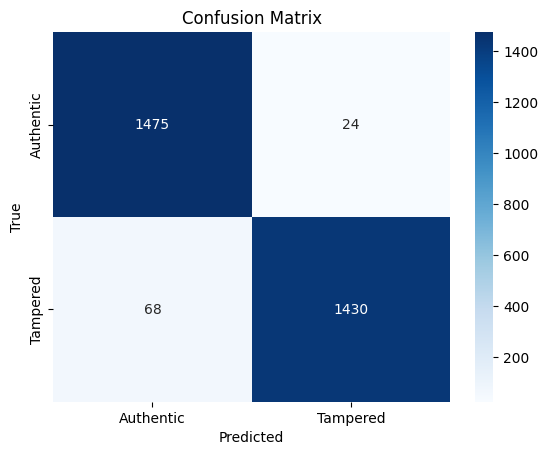

Classification Report:

              precision    recall  f1-score   support

   Authentic       0.96      0.98      0.97      1499
    Tampered       0.98      0.95      0.97      1498

    accuracy                           0.97      2997
   macro avg       0.97      0.97      0.97      2997
weighted avg       0.97      0.97      0.97      2997


Additional Evaluation Metrics:
Accuracy   : 0.9693
Precision  : 0.9835
Recall     : 0.9546
Specificity: 0.9840
F1 Score   : 0.9688
AUC        : 0.9948
Z1 Score   : 0.9764


In [ ]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Evaluate the model
val_loss, val_acc, preds, labels, probs = evaluate(model, test_loader, loss_fn, device)

# Confusion Matrix
cm = confusion_matrix(labels, preds)
tn, fp, fn, tp = cm.ravel()

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Authentic", "Tampered"],
            yticklabels=["Authentic", "Tampered"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(labels, preds, target_names=["Authentic", "Tampered"]))

# Metrics Calculation
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
f1 = f1_score(labels, preds)

# ROC AUC
try:
    auc = roc_auc_score(labels, probs)
except ValueError:
    auc = None
    print("ROC AUC cannot be computed (check label variety).")

# Z1 Score (You can define it differently; here’s one example based on F1 and Specificity)
z1_score = (2 * f1 * specificity) / (f1 + specificity) if (f1 + specificity) != 0 else 0

# Display Metrics
print("\nAdditional Evaluation Metrics:")
print(f"Accuracy   : {accuracy:.4f}")
print(f"Precision  : {precision:.4f}")
print(f"Recall     : {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score   : {f1:.4f}")
print(f"AUC        : {auc:.4f}" if auc is not None else "AUC        : N/A")
print(f"Z1 Score   : {z1_score:.4f}")


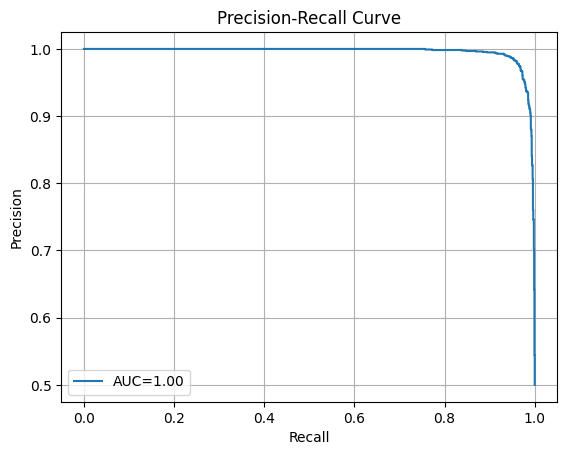

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, _ = precision_recall_curve(labels, probs)
pr_auc = auc(recall, precision)

plt.plot(recall, precision, label=f"AUC={pr_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


# Experimentation Below
#### (Below Stuff is not supposed to be shown; All showable contents are above)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("divg07/casia-20-image-tampering-detection-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/casia-20-image-tampering-detection-dataset


In [ ]:
! rm -r /content/Dataset/CASIA_YOLOv8_Labels

In [ ]:
! mv /kaggle/input/casia-20-image-tampering-detection-dataset/* /content/

Streaming output truncated to the last 5000 lines.
mv: cannot remove '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp/Tp_S_NNN_S_N_ani00086_ani00086_11125.jpg': Read-only file system
mv: cannot remove '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp/Tp_S_NNN_S_N_art00017_art00017_00920.tif': Read-only file system
mv: cannot remove '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp/Tp_S_NND_S_N_ani00072_ani00072_00192.tif': Read-only file system
mv: cannot remove '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp/Tp_S_NNN_S_N_sec00024_sec00024_00747.tif': Read-only file system
mv: cannot remove '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp/Tp_S_NNN_S_N_arc20091_arc20091_01731.tif': Read-only file system
mv: cannot remove '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp/Tp_D_NNN_S_N_nat00007_ani00021_00627.tif': Read-only file system
mv: cannot remove '/kaggle/input/casia-20-i

In [ ]:
# Tp_D_CND_M_N_ani00018_sec00096_00138.tif
# Tp_D_CND_M_N_ani00018_sec00096_00138_gt.png

gt_path = '/content/Dataset/Tp_Labels'
tp_path = '/content/Dataset/Tp'

import os

paired = []

gt_imgs = set(os.listdir(gt_path))
tp_imgs = os.listdir(tp_path)[1:]


for i in range(min(len(gt_imgs), len(tp_imgs))):

  tp_img = tp_imgs[i]
  # print(gt_img, tp_img)
  if (tp_img[:-4] + '_gt.txt') in gt_imgs:
    paired.append(['/content/Dataset/Tp/' + tp_img, ('/content/Dataset/Tp_Labels/' + tp_img[:-4] + '_gt.txt')])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

paired = np.array(paired)
paired.shape

(4979, 2)

In [ ]:
paired[0]

array(['/content/Dataset/Tp/Tp_S_NNN_S_N_art00008_art00008_01198.tif',
       '/content/Dataset/Tp_Labels/Tp_S_NNN_S_N_art00008_art00008_01198_gt.txt'],
      dtype='<U70')

In [ ]:
# Checking Only

import os

os.path.exists('/content/Dataset/Tp_Labels/Tp_S_NNN_S_N_art00008_art00008_01198_gt.txt')

# len(os.listdir('/content/Dataset/CASIA_YOLOv8_Labels'))

True

In [ ]:
import os
import cv2
import numpy as np
from pathlib import Path

# ==== CONFIG ====
MASK_DIR  = "/content/CASIA2/CASIA 2 Groundtruth"  # directory with tamper masks (.png)
OUTPUT_LABEL_DIR = "/content/Dataset/CASIA_YOLOv8_Labels"                # where YOLO .txt files will go

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_LABEL_DIR, exist_ok=True)

# ==== UTILITY FUNCTIONS ====
def clamp01(x):
    return max(0.0, min(1.0, x))

def mask_to_yolo_labels(mask_path, img_w, img_h):
    """
    Converts a single binary mask image to YOLO bounding box labels.
    Returns a list of label strings: ["0 x_center y_center width height"]
    """
    img_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if img_mask is None:
        return []

    _, binary = cv2.threshold(img_mask, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    labels = []
    for cnt in contours:
        if cv2.contourArea(cnt) < 10:  # Skip very small regions
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        x_center = clamp01((x + w / 2) / img_w)
        y_center = clamp01((y + h / 2) / img_h)
        width = clamp01(w / img_w)
        height = clamp01(h / img_h)
        labels.append(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
    return labels

# ==== PROCESS ALL MASKS ====
mask_paths = sorted(Path(MASK_DIR).glob("*.png"))
count = 0

for mask_path in mask_paths:
    mask_img = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if mask_img is None:
        print(f"❌ Failed to read mask: {mask_path}")
        continue

    h, w = mask_img.shape[:2]
    labels = mask_to_yolo_labels(mask_path, w, h)

    # Save label file
    output_txt_path = Path(OUTPUT_LABEL_DIR) / f"{mask_path.stem.replace('_gt', '_gt')}.txt"
    with open(output_txt_path, "w") as f:
        f.write("\n".join(labels))
    count += 1

print(f"✅ Generated labels for {count} mask files.")


✅ Generated labels for 5123 mask files.


In [ ]:
import os
from pathlib import Path

# Paths
AUTHENTIC_IMG_DIR = "/content/Dataset/Au"
OUTPUT_LABEL_DIR  = "/content/Dataset/Au_Labels"

# Image extensions to consider
image_exts = [".jpg", ".tif", ".png"]

# Collect image filenames (no extension)
authentic_img_names = {
    Path(p).stem for ext in image_exts for p in Path(AUTHENTIC_IMG_DIR).glob(f"*{ext}")
}

# Create empty .txt labels if not already created
count = 0
for name in authentic_img_names:
    label_path = Path(OUTPUT_LABEL_DIR) / f"{name}.txt"
    if not label_path.exists():
        label_path.touch()  # create an empty file
        count += 1

print(f"✅ Created {count} empty label files for authentic (untampered) images.")

✅ Created 7437 empty label files for authentic (untampered) images.


# Copy-Move & Splicing Localization

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("divg07/casia-20-image-tampering-detection-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.56G/2.56G [00:31<00:00, 86.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/divg07/casia-20-image-tampering-detection-dataset/versions/1


In [ ]:
! mv /root/.cache/kagglehub/datasets/divg07/casia-20-image-tampering-detection-dataset/versions/1/* /content

In [ ]:
! rm -r /content/CASIA2/Au

In [ ]:
import os
import cv2
import shutil
import random
from pathlib import Path

# ==== INPUT FOLDERS ====
BASE_DIR = "/content/CASIA2"
TAMPERED_DIR = os.path.join(BASE_DIR, "Tp")
MASK_DIR = os.path.join(BASE_DIR, "CASIA 2 Groundtruth")
# AUTHENTIC_DIR = os.path.join(BASE_DIR, "Au")

# ==== OUTPUT FOLDERS ====
OUTPUT_BASE = "/content/CASIA_YOLOv8_ready"
IMAGE_DIR = os.path.join(OUTPUT_BASE, "images")
LABEL_DIR = os.path.join(OUTPUT_BASE, "labels")

# Train/Val split
SPLIT_RATIO = 0.8
random.seed(42)  # Reproducibility

# ==== UTIL FUNCTIONS ====
def clamp01(x):
    return max(0.0, min(1.0, x))

def get_yolo_label_from_mask(mask_path, img_shape):
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return []

    h, w = img_shape
    _, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    labels = []
    for cnt in contours:
        if cv2.contourArea(cnt) < 10:
            continue
        x, y, bw, bh = cv2.boundingRect(cnt)
        x_center = clamp01((x + bw / 2) / w)
        y_center = clamp01((y + bh / 2) / h)
        width = clamp01(bw / w)
        height = clamp01(bh / h)
        labels.append(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
    return labels

def save_image_and_label(src_img, dst_img_dir, dst_lbl_dir, label_lines):
    dst_name = Path(src_img).stem
    ext = Path(src_img).suffix

    # Copy image
    shutil.copy2(src_img, os.path.join(dst_img_dir, dst_name + ext))

    # Write label file
    with open(os.path.join(dst_lbl_dir, dst_name + ".txt"), "w") as f:
        f.write("\n".join(label_lines))

# ==== STEP 1: PAIR TAMPERED IMAGES AND MASKS ====
tampered_imgs = [f for f in os.listdir(TAMPERED_DIR) if f.lower().endswith(('.jpg', '.tif'))]
mask_files = set([f for f in os.listdir(MASK_DIR) if f.lower().endswith('.png')])

paired_tampered = []
for tp_img in tampered_imgs:
    base = Path(tp_img).stem
    mask_name = base + "_gt.png"
    if mask_name in mask_files:
        paired_tampered.append((tp_img, mask_name))

print(f"✅ Found {len(paired_tampered)} valid tampered-mask pairs")

# ==== STEP 2: AUTHENTIC IMAGES ====
# authentic_imgs = [f for f in os.listdir(AUTHENTIC_DIR) if f.lower().endswith(('.jpg', '.tif'))]
# print(f"📦 Found {len(authentic_imgs)} authentic images")

# ==== STEP 3: BALANCE DATASET ====
N = len(paired_tampered)
paired_tampered = random.sample(paired_tampered, N)

print(f"📊 Balanced dataset to {N} authentic and {N} tampered images")

# ==== STEP 4: TRAIN/VAL SPLIT ====
indices = list(range(N))
random.shuffle(indices)
split_idx = int(SPLIT_RATIO * N)
train_idx = indices[:split_idx]
val_idx = indices[split_idx:]

def prepare_dirs(split):
    os.makedirs(os.path.join(IMAGE_DIR, split), exist_ok=True)
    os.makedirs(os.path.join(LABEL_DIR, split), exist_ok=True)

prepare_dirs("train")
prepare_dirs("val")

# ==== STEP 5: PROCESS TAMPERED ====
for i in range(N):
    img_file, mask_file = paired_tampered[i]
    split = "train" if i in train_idx else "val"

    img_path = os.path.join(TAMPERED_DIR, img_file)
    mask_path = os.path.join(MASK_DIR, mask_file)

    # Load image shape for label normalization
    img = cv2.imread(img_path)
    if img is None:
        continue
    h, w = img.shape[:2]

    # Get labels from mask
    labels = get_yolo_label_from_mask(mask_path, (w, h))

    # Save image and corresponding label
    save_image_and_label(img_path,
                         os.path.join(IMAGE_DIR, split),
                         os.path.join(LABEL_DIR, split),
                         labels)

# ==== STEP 6: PROCESS AUTHENTIC ====
# for i in range(N):
#     img_file = authentic_imgs[i]
#     split = "train" if i in train_idx else "val"

#     img_path = os.path.join(AUTHENTIC_DIR, img_file)

#     # Empty label for authentic images
#     save_image_and_label(img_path,
#                          os.path.join(IMAGE_DIR, split),
#                          os.path.join(LABEL_DIR, split),
#                          [])

# print(f"✅ Final YOLO-ready dataset created at: {OUTPUT_BASE}")


✅ Found 4981 valid tampered-mask pairs
📊 Balanced dataset to 4981 authentic and 4981 tampered images


In [ ]:
import os

# print(os.path.exists('/content/CASIA_YOLOv8_ready/labels/train/Au_ani_00032.txt'))
print(len(os.listdir('/content/CASIA_YOLOv8_ready/labels/train')))

3984


In [ ]:
import os
from collections import defaultdict
cnt = defaultdict(int)

for i in os.listdir('/content/CASIA_YOLOv8_ready/images/train'):
  cnt[i.split('.')[1]] += 1

print(cnt)

cnt = defaultdict(int)

for i in os.listdir('/content/CASIA_YOLOv8_ready/images/val'):
  cnt[i.split('.')[1]] += 1

print(cnt)

defaultdict(<class 'int'>, {'tif': 2388, 'jpg': 1596})
defaultdict(<class 'int'>, {'tif': 589, 'jpg': 408})


In [ ]:
def verify_all_rgb(folder_path):
    from PIL import Image
    import os
    for subdir, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff')):
                path = os.path.join(subdir, file)
                try:
                    with Image.open(path) as img:
                        if img.mode != 'RGB':
                            print(f"❌ Not RGB: {path} -> {img.mode}")
                            return
                except Exception as e:
                    print(f"⚠️ Error opening {path}: {e}")
    print("✅ All images are RGB")


verify_all_rgb('/content/casia_clean/images')


✅ All images are RGB


In [ ]:
def convert_all_to_rgb_jpg(src_dir, dst_dir):
    import os
    from PIL import Image

    os.makedirs(dst_dir, exist_ok=True)

    for subdir, _, files in os.walk(src_dir):
        rel_path = os.path.relpath(subdir, src_dir)
        out_subdir = os.path.join(dst_dir, rel_path)
        os.makedirs(out_subdir, exist_ok=True)

        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff')):
                src_path = os.path.join(subdir, file)
                dst_file = os.path.splitext(file)[0] + '.jpg'
                dst_path = os.path.join(out_subdir, dst_file)

                try:
                    with Image.open(src_path) as img:
                        if img.mode != 'RGB':
                            img = img.convert('RGB')
                        img.save(dst_path, 'JPEG')
                except Exception as e:
                    print(f"❌ Failed: {src_path} — {e}")

convert_all_to_rgb_jpg('/content/CASIA_YOLOv8_ready/images', '/content/casia_clean/images')


In [ ]:
! cp -r /content/CASIA_YOLOv8_ready/labels /content/casia_clean/labels

In [ ]:
from PIL import Image
import os

def convert_to_rgb(root_folder):
    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(subdir, file)
                try:
                    img = Image.open(img_path)
                    if img.mode != 'RGB':
                        img = img.convert('RGB')
                        img.save(img_path)
                        print(f'Converted: {img_path}')
                except Exception as e:
                    print(f'Error processing {img_path}: {e}')

# Replace this with your actual images folder
convert_to_rgb('/content/casia_clean/images')


In [ ]:
from PIL import Image
import os

def check_image_modes(folder_path):
    non_rgb_images = []
    for subdir, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(subdir, file)
                try:
                    with Image.open(img_path) as img:
                        if img.mode != 'RGB':
                            non_rgb_images.append((img_path, img.mode))
                except Exception as e:
                    print(f'Error opening {img_path}: {e}')

    if non_rgb_images:
        print("❗ Non-RGB images found:")
        for path, mode in non_rgb_images:
            print(f"{path} - Mode: {mode}")
    else:
        print("✅ All images are in RGB mode!")

# Change this to your dataset image directory
check_image_modes('/content/casia_clean/images')

✅ All images are in RGB mode!


In [ ]:
! pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [ ]:
! cd casia_clean

! tree /f

/bin/bash: line 1: tree: command not found


In [ ]:
from ultralytics import YOLO

# Load YOLOv8 small model (you can use s, m, l, x depending on your hardware and desired performance)
model = YOLO('yolov8l.pt')  # 'yolov8s.pt' for small, you can also use 'yolov8m.pt', 'yolov8l.pt', 'yolov8x.pt'

model.train(data='/content/casia.yaml',
            epochs=20,
            imgsz=384,  # Use the native image size for training
            batch=32,
            save_period=1,
            project='/content/yolov8_casia',
            name='casia_model',
            save=True,
            verbose=True,
            exist_ok=True)

Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/casia.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=384, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=casia_model, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, 

train: Scanning /content/casia_clean/labels/train... 3984 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3984/3984 [00:03<00:00, 1069.15it/s]


train: New cache created: /content/casia_clean/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 146.8±48.7 MB/s, size: 37.0 KB)


val: Scanning /content/casia_clean/labels/val... 997 images, 0 backgrounds, 0 corrupt: 100%|██████████| 997/997 [00:01<00:00, 678.84it/s]


val: New cache created: /content/casia_clean/labels/val.cache
Plotting labels to /content/yolov8_casia/casia_model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 384 train, 384 val
Using 2 dataloader workers
Logging results to /content/yolov8_casia/casia_model
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      7.09G      1.522      2.658      1.541         29        384: 100%|██████████| 125/125 [01:19<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  69%|██████▉   | 11/16 [00:06<00:02,  1.82it/s]


KeyboardInterrupt: 

In [ ]:
import cv2
import os
import numpy as np

def mask_to_yolo_seg(mask_path, label_path, class_id=0):
    # Read mask (white = tampered, black = authentic)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    h, w = mask.shape

    # Find contours (external edges of white regions)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    with open(label_path, "w") as f:
        for contour in contours:
            # Flatten contour array and normalize
            poly = contour.reshape(-1, 2)
            poly = poly.astype(float)
            poly[:, 0] /= w  # normalize x
            poly[:, 1] /= h  # normalize y

            # Skip very small polygons
            if len(poly) < 3:
                continue

            # Write line: class_id + polygon points
            line = f"{class_id} " + " ".join([f"{x:.6f} {y:.6f}" for x, y in poly])
            f.write(line + "\n")

In [ ]:
mask_to_yolo_seg("/content/test_mask_1.png", "/content/labels/mask.txt")

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_yolo_mask(label_path, img_size=(512, 512)):
    """
    Visualize YOLOv8-Seg polygon mask.
    - label_path: path to .txt label file
    - img_size: (width, height) of target mask to render
    """
    w, h = img_size
    mask = np.zeros((h, w), dtype=np.uint8)

    with open(label_path, "r") as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) < 6:
                continue  # need at least 3 points

            # Skip class_id, keep coords
            coords = list(map(float, parts[1:]))
            poly = np.array(coords).reshape(-1, 2)

            # Convert back to pixel coords
            poly[:, 0] *= w
            poly[:, 1] *= h
            poly = poly.astype(np.int32)

            # Draw filled polygon
            cv2.fillPoly(mask, [poly], 255)

    # Plot result
    plt.imshow(mask, cmap="gray")
    plt.axis("off")
    plt.show()

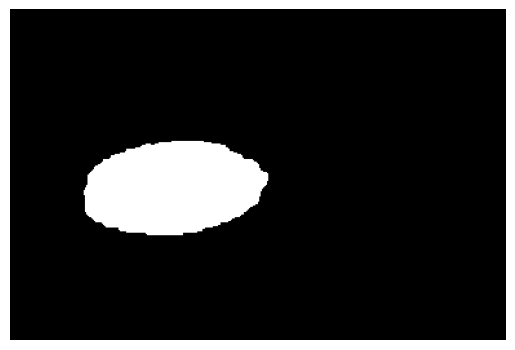

In [ ]:
visualize_yolo_mask("labels/mask.txt", img_size=(384, 256))

In [ ]:
import os
import cv2
import shutil
import random
from pathlib import Path

# ==== INPUT FOLDERS ====
BASE_DIR = "/content/CASIA2"
TAMPERED_DIR = os.path.join(BASE_DIR, "Tp")
MASK_DIR = os.path.join(BASE_DIR, "CASIA 2 Groundtruth")

# ==== OUTPUT FOLDERS ====
OUTPUT_BASE = "/content/CASIA_YOLOv8_ready"
IMAGE_DIR = os.path.join(OUTPUT_BASE, "images")
LABEL_DIR = os.path.join(OUTPUT_BASE, "labels")

# Train/Val split
SPLIT_RATIO = 0.8
random.seed(42)  # reproducibility

# ==== SUPPORTED EXTENSIONS ====
IMG_EXTS = (".jpg", ".jpeg", ".png", ".tif", ".tiff")

# ==== MASK → YOLO POLYGONS ====
def mask_to_yolo_seg(mask_path, label_path, class_id=0):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return

    h, w = mask.shape
    _, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    with open(label_path, "w") as f:
        for contour in contours:
            if cv2.contourArea(contour) < 10:
                continue
            poly = contour.reshape(-1, 2).astype(float)
            poly[:, 0] /= w
            poly[:, 1] /= h

            # skip too small polygons
            if len(poly) < 3:
                continue

            line = f"{class_id} " + " ".join([f"{x:.6f} {y:.6f}" for x, y in poly])
            f.write(line + "\n")

# ==== SAVE IMAGE + LABEL ====
def save_image_and_label(src_img, src_mask, dst_img_dir, dst_lbl_dir):
    dst_name = Path(src_img).stem
    ext = Path(src_img).suffix

    # Copy image
    shutil.copy2(src_img, os.path.join(dst_img_dir, dst_name + ext))

    # Generate label
    label_file = os.path.join(dst_lbl_dir, dst_name + ".txt")
    mask_to_yolo_seg(src_mask, label_file, class_id=0)

# ==== STEP 1: PAIR IMAGES + MASKS ====
tampered_imgs = [f for f in os.listdir(TAMPERED_DIR) if f.lower().endswith(IMG_EXTS)]
mask_files = set([f for f in os.listdir(MASK_DIR) if f.lower().endswith(".png")])

paired = []
for tp_img in tampered_imgs:
    base = Path(tp_img).stem
    mask_name = base + "_gt.png"
    if mask_name in mask_files:
        paired.append((tp_img, mask_name))

print(f"✅ Found {len(paired)} valid tampered-mask pairs")

# ==== STEP 2: SHUFFLE + SPLIT ====
N = len(paired)
indices = list(range(N))
random.shuffle(indices)
split_idx = int(SPLIT_RATIO * N)
train_idx = set(indices[:split_idx])
val_idx = set(indices[split_idx:])

# ==== PREPARE DIRS ====
def prepare_dirs(split):
    os.makedirs(os.path.join(IMAGE_DIR, split), exist_ok=True)
    os.makedirs(os.path.join(LABEL_DIR, split), exist_ok=True)

prepare_dirs("train")
prepare_dirs("val")

# ==== STEP 3: PROCESS ====
for i, (img_file, mask_file) in enumerate(paired):
    split = "train" if i in train_idx else "val"

    img_path = os.path.join(TAMPERED_DIR, img_file)
    mask_path = os.path.join(MASK_DIR, mask_file)

    save_image_and_label(img_path,
                         mask_path,
                         os.path.join(IMAGE_DIR, split),
                         os.path.join(LABEL_DIR, split))

print("🎉 Dataset ready in YOLOv8-Seg format")


✅ Found 4981 valid tampered-mask pairs
🎉 Dataset ready in YOLOv8-Seg format


In [ ]:
import cv2
import os
from glob import glob
from tqdm import tqdm

image_dir = "/content/CASIA_YOLOv8_ready/images"  # adjust path

for path in tqdm(glob(f"{image_dir}/**/*.jpg", recursive=True) + glob(f"{image_dir}/**/*.png", recursive=True)):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)  # loads all channels
    if img is None:
        continue
    if img.shape[-1] == 4:  # RGBA -> RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
        cv2.imwrite(path, img)
    elif img.shape[-1] == 1:  # grayscale -> RGB
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        cv2.imwrite(path, img)


100%|██████████| 2004/2004 [00:07<00:00, 268.03it/s]


In [ ]:
import cv2
from glob import glob

for path in glob(f"{image_dir}/**/*.jpg", recursive=True) + glob(f"{image_dir}/**/*.png", recursive=True):
    img = cv2.imread(path)
    if img is None or img.shape[-1] != 3:
        print("Problematic file:", path)


In [ ]:
!pip install ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.0 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

# Path to YAML (created earlier)
DATA_YAML = "/content/casia.yaml"

# Choose YOLOv8 small segmentation model as baseline
model = YOLO("yolov8s-seg.pt")


In [ ]:
results = model.train(
    data=DATA_YAML,
    epochs=50,
    imgsz=512,
    batch=16,
    optimizer="AdamW",
    lr0=1e-3,
    patience=8,   # early stopping
    cos_lr=True,   # cosine annealing schedule
    weight_decay=0.0005,
    device=0  # use GPU
)

Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/casia.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=8, perspective=0.0, plots=True, pose=12.0, pretrained=True, p

train: Scanning /content/casia_clean/labels/train.cache... 3984 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3984/3984 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 360.2±128.4 MB/s, size: 37.0 KB)


val: Scanning /content/casia_clean/labels/val.cache... 997 images, 0 backgrounds, 0 corrupt: 100%|██████████| 997/997 [00:00<?, ?it/s]


Plotting labels to runs/segment/train3/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/segment/train3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.14G      1.386      2.775       2.68       1.38         36        512: 100%|██████████| 249/249 [01:21<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.05it/s]


                   all        997       1139      0.149      0.196     0.0933     0.0534       0.15      0.133     0.0655     0.0384

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.42G      1.517      2.814      2.559      1.473         43        512: 100%|██████████| 249/249 [01:17<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.07it/s]


                   all        997       1139      0.253      0.187      0.135     0.0727      0.249      0.165      0.113     0.0545

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.44G       1.56      2.932      2.649      1.514         32        512: 100%|██████████| 249/249 [01:16<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.90it/s]


                   all        997       1139      0.244      0.224      0.156     0.0881      0.267      0.221      0.163     0.0912

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.74G       1.55      2.898      2.607      1.515         31        512: 100%|██████████| 249/249 [01:17<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.23it/s]


                   all        997       1139       0.24      0.223      0.158     0.0922      0.273      0.214      0.167      0.095

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.74G      1.493      2.775      2.518      1.472         37        512: 100%|██████████| 249/249 [01:15<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  2.97it/s]


                   all        997       1139      0.247      0.214       0.14     0.0855      0.249      0.216      0.142     0.0868

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.78G      1.427      2.707      2.485      1.431         39        512: 100%|██████████| 249/249 [01:16<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.22it/s]


                   all        997       1139      0.324      0.218      0.183      0.116      0.329       0.22      0.182      0.113

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.78G      1.395      2.625      2.427       1.42         37        512: 100%|██████████| 249/249 [01:16<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.25it/s]


                   all        997       1139      0.317       0.29      0.225      0.148      0.318      0.292      0.223      0.142

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.79G      1.359      2.546      2.394      1.399         43        512: 100%|██████████| 249/249 [01:16<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  2.94it/s]


                   all        997       1139      0.357      0.239      0.224      0.143      0.363      0.239       0.22       0.14

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.79G      1.326      2.498      2.346       1.38         41        512: 100%|██████████| 249/249 [01:16<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  2.97it/s]


                   all        997       1139      0.403      0.246      0.243      0.168      0.404      0.247      0.241       0.16

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.79G      1.285       2.46      2.296      1.357         70        512: 100%|██████████| 249/249 [01:15<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.18it/s]


                   all        997       1139      0.375      0.276      0.253      0.179      0.372      0.273       0.25      0.174

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.79G      1.284      2.402       2.27      1.354         32        512: 100%|██████████| 249/249 [01:15<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  2.99it/s]


                   all        997       1139      0.371      0.262      0.226      0.158      0.362      0.265      0.221      0.145

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.79G       1.27      2.425      2.272      1.333         40        512: 100%|██████████| 249/249 [01:15<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.22it/s]


                   all        997       1139      0.427      0.303      0.283      0.201      0.417      0.308      0.282      0.198

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.79G      1.232      2.319      2.179      1.307         36        512: 100%|██████████| 249/249 [01:15<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.26it/s]


                   all        997       1139      0.402      0.309      0.293      0.213      0.401      0.313      0.291      0.205

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.79G      1.215       2.28      2.165      1.304         30        512: 100%|██████████| 249/249 [01:16<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.26it/s]


                   all        997       1139      0.376      0.297      0.276      0.197       0.37      0.304      0.276      0.191

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.79G      1.206      2.245      2.135      1.298         37        512: 100%|██████████| 249/249 [01:16<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.24it/s]


                   all        997       1139      0.398      0.309      0.267      0.194       0.39      0.311      0.264      0.188

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.79G      1.165      2.194      2.073      1.269         37        512: 100%|██████████| 249/249 [01:16<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.25it/s]


                   all        997       1139      0.413      0.305      0.302      0.223      0.426      0.307      0.303      0.215

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.79G      1.139      2.148      2.045      1.256         30        512: 100%|██████████| 249/249 [01:16<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.27it/s]


                   all        997       1139      0.445      0.314      0.298      0.222       0.46      0.305      0.296      0.211

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.79G      1.152      2.168      2.059      1.266         44        512: 100%|██████████| 249/249 [01:15<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.22it/s]


                   all        997       1139       0.44      0.318      0.316      0.233      0.444      0.316      0.315      0.221

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.82G      1.128      2.126      2.001      1.248         26        512: 100%|██████████| 249/249 [01:15<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.31it/s]


                   all        997       1139      0.466      0.322      0.335      0.248      0.466      0.322      0.335      0.237

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.86G      1.105      2.059      1.969      1.238         26        512: 100%|██████████| 249/249 [01:15<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.23it/s]


                   all        997       1139      0.435      0.345      0.331      0.248      0.444      0.344      0.334      0.242

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.86G      1.087      2.054       1.95      1.226         29        512: 100%|██████████| 249/249 [01:16<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.27it/s]


                   all        997       1139      0.469      0.328      0.347      0.261      0.474      0.323      0.347       0.25

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.86G      1.067      2.003      1.926      1.212         28        512: 100%|██████████| 249/249 [01:15<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.41it/s]


                   all        997       1139      0.443      0.321      0.337      0.254       0.45      0.312      0.335      0.244

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.86G      1.057       1.96      1.877      1.206         32        512: 100%|██████████| 249/249 [01:15<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.32it/s]


                   all        997       1139        0.5      0.326      0.354      0.273      0.504      0.323      0.353       0.26

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.86G      1.045      1.938      1.851      1.188         32        512: 100%|██████████| 249/249 [01:15<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.36it/s]


                   all        997       1139      0.529      0.354      0.381      0.287      0.539      0.355      0.379      0.277

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.86G       1.03      1.903      1.816      1.186         36        512: 100%|██████████| 249/249 [01:15<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.30it/s]


                   all        997       1139      0.505      0.354      0.372      0.288      0.503      0.352      0.371      0.268

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.86G      1.002      1.853      1.771      1.169         33        512: 100%|██████████| 249/249 [01:16<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.27it/s]


                   all        997       1139      0.529      0.345      0.373      0.288      0.537       0.35      0.374      0.275

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.86G     0.9654      1.801      1.722      1.148         31        512: 100%|██████████| 249/249 [01:15<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.24it/s]


                   all        997       1139      0.535       0.35      0.397      0.307      0.543      0.356      0.401      0.292

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.86G     0.9857      1.844      1.723      1.165         35        512: 100%|██████████| 249/249 [01:16<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.31it/s]


                   all        997       1139      0.468      0.384      0.394        0.3      0.471      0.382      0.392      0.288

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.86G     0.9635      1.792      1.679      1.153         47        512: 100%|██████████| 249/249 [01:15<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.30it/s]


                   all        997       1139      0.527      0.366      0.395      0.301      0.527      0.366      0.392      0.286

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.86G      0.948      1.766      1.658      1.146         33        512: 100%|██████████| 249/249 [01:15<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.06it/s]


                   all        997       1139        0.5      0.406      0.401      0.319      0.503      0.408      0.402      0.301

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.86G     0.9134      1.668      1.611      1.122         38        512: 100%|██████████| 249/249 [01:15<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.20it/s]

                   all        997       1139      0.536      0.378       0.42       0.33       0.55      0.381      0.418      0.314



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.86G     0.9152      1.713      1.587      1.113         33        512: 100%|██████████| 249/249 [01:16<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.22it/s]


                   all        997       1139      0.579      0.385      0.423      0.334      0.584      0.387      0.426      0.313

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.86G     0.8987      1.644       1.55      1.108         42        512: 100%|██████████| 249/249 [01:16<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.02it/s]

                   all        997       1139      0.582      0.378      0.427      0.332      0.583      0.379      0.427       0.31



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.86G     0.8784       1.64      1.512      1.097         28        512: 100%|██████████| 249/249 [01:15<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.22it/s]


                   all        997       1139      0.563      0.386      0.429      0.329       0.57      0.378      0.426      0.314

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.86G     0.8821       1.64      1.499      1.102         32        512: 100%|██████████| 249/249 [01:15<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.41it/s]

                   all        997       1139      0.549      0.404      0.435      0.345      0.553      0.406      0.436      0.324



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.86G     0.8581       1.59      1.444      1.087         37        512: 100%|██████████| 249/249 [01:16<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.32it/s]

                   all        997       1139      0.563      0.409      0.454      0.355      0.573      0.404       0.45      0.336



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.86G     0.8588      1.597      1.445      1.085         44        512: 100%|██████████| 249/249 [01:16<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.29it/s]


                   all        997       1139      0.593      0.413      0.437      0.344        0.6      0.417      0.443      0.326

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.86G     0.8509      1.548      1.405      1.077         30        512: 100%|██████████| 249/249 [01:16<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.35it/s]

                   all        997       1139      0.582      0.413      0.452      0.357      0.578      0.419       0.45      0.336



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.86G     0.8445      1.562      1.409      1.074         29        512: 100%|██████████| 249/249 [01:15<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.37it/s]

                   all        997       1139      0.561       0.42      0.457      0.362      0.581      0.417      0.459      0.342



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.86G     0.8256      1.525       1.37      1.064         41        512: 100%|██████████| 249/249 [01:15<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.32it/s]

                   all        997       1139      0.607      0.411      0.452      0.358      0.616      0.415      0.455      0.335


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.86G     0.8189      1.504      1.341      1.068         18        512: 100%|██████████| 249/249 [01:15<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.13it/s]

                   all        997       1139      0.604      0.409      0.455      0.355      0.606       0.41      0.451      0.333



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.86G     0.7937      1.467      1.237      1.051         19        512: 100%|██████████| 249/249 [01:13<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.22it/s]


                   all        997       1139      0.637      0.404      0.464      0.361      0.638      0.405      0.462       0.34

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.86G     0.7787      1.423      1.198       1.04         19        512: 100%|██████████| 249/249 [01:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.16it/s]


                   all        997       1139      0.613      0.408      0.457      0.359      0.604      0.413      0.455      0.336

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.86G     0.7752      1.404      1.164      1.044         38        512: 100%|██████████| 249/249 [01:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.05it/s]

                   all        997       1139      0.622      0.407      0.459      0.361      0.624      0.409       0.46      0.338



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.86G     0.7571      1.395      1.139       1.03         20        512: 100%|██████████| 249/249 [01:13<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.30it/s]

                   all        997       1139      0.651      0.393      0.462      0.363      0.662      0.392      0.463      0.343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.86G     0.7537      1.372      1.123      1.028         18        512: 100%|██████████| 249/249 [01:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.24it/s]

                   all        997       1139      0.655      0.409      0.472      0.372      0.657      0.406       0.47      0.349



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.86G     0.7447      1.379      1.117      1.029         16        512: 100%|██████████| 249/249 [01:13<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  2.98it/s]

                   all        997       1139      0.627      0.423      0.468      0.369      0.632      0.424      0.471      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.86G     0.7434      1.368      1.111      1.022         16        512: 100%|██████████| 249/249 [01:13<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.46it/s]


                   all        997       1139      0.688      0.398      0.472      0.371      0.686      0.399      0.472      0.351

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.86G     0.7454      1.376      1.102       1.02         23        512: 100%|██████████| 249/249 [01:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.33it/s]

                   all        997       1139      0.652      0.406       0.47       0.37       0.65      0.406      0.469      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.86G     0.7433      1.357       1.09      1.027         15        512: 100%|██████████| 249/249 [01:12<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.30it/s]

                   all        997       1139      0.628      0.428      0.472       0.37      0.628      0.428      0.471      0.348



50 epochs completed in 1.317 hours.
Optimizer stripped from runs/segment/train3/weights/last.pt, 23.8MB
Optimizer stripped from runs/segment/train3/weights/best.pt, 23.8MB

Validating runs/segment/train3/weights/best.pt...
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-seg summary (fused): 85 layers, 11,779,987 parameters, 0 gradients, 42.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/32 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   3%|▎         | 1/32 [00:00<00:11,  2.58it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   6%|▋         | 2/32 [00:01<00:21,  1.38it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  2.95it/s]


                   all        997       1139      0.686      0.398      0.472      0.371      0.686      0.399      0.472      0.351
Speed: 0.1ms preprocess, 2.7ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/segment/train3


In [ ]:
! pip show transformers

Name: transformers
Version: 4.55.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.12/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("defactodataset/defactoinpainting")

print("Path to dataset files:", path)

100%|██████████| 12.2G/12.2G [09:50<00:00, 22.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/defactodataset/defactoinpainting/versions/6


In [ ]:
import os

print(os.listdir(path))

['inpainting_img', 'inpainting_annotations']


In [ ]:
! mv /root/.cache/kagglehub/datasets/defactodataset/defactoinpainting/versions/6/* /content/Dataset/

In [ ]:
import os
import cv2
import shutil
import random
from pathlib import Path

# ==== INPUT FOLDERS ====
BASE_DIR = "/content/Dataset"
TAMPERED_DIR = os.path.join(BASE_DIR, "inpainting_img")
MASK_DIR = os.path.join(BASE_DIR, "inpainting_annotations")

# ==== OUTPUT FOLDERS ====
OUTPUT_BASE = "/content/inpainting_ds"
IMAGE_DIR = os.path.join(OUTPUT_BASE, "images")
LABEL_DIR = os.path.join(OUTPUT_BASE, "labels")

# Train/Val split
SPLIT_RATIO = 0.8
random.seed(42)  # reproducibility

# ==== SUPPORTED EXTENSIONS ====
IMG_EXTS = (".jpg", ".jpeg", ".png", ".tif", ".tiff")

# ==== MASK → YOLO POLYGONS ====
def mask_to_yolo_seg(mask_path, label_path, class_id=0):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return

    h, w = mask.shape
    _, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    with open(label_path, "w") as f:
        for contour in contours:
            if cv2.contourArea(contour) < 10:
                continue
            poly = contour.reshape(-1, 2).astype(float)
            poly[:, 0] /= w
            poly[:, 1] /= h

            # skip too small polygons
            if len(poly) < 3:
                continue

            line = f"{class_id} " + " ".join([f"{x:.6f} {y:.6f}" for x, y in poly])
            f.write(line + "\n")

# ==== SAVE IMAGE + LABEL ====
def save_image_and_label(src_img, src_mask, dst_img_dir, dst_lbl_dir):
    dst_name = Path(src_img).stem
    ext = Path(src_img).suffix

    # Copy image
    shutil.copy2(src_img, os.path.join(dst_img_dir, dst_name + ext))

    # Generate label
    label_file = os.path.join(dst_lbl_dir, dst_name + ".txt")
    mask_to_yolo_seg(src_mask, label_file, class_id=0)

# ==== STEP 1: PAIR IMAGES + MASKS ====
tampered_imgs = [f for f in os.listdir(TAMPERED_DIR) if f.lower().endswith(IMG_EXTS)]
mask_files = set([f for f in os.listdir(MASK_DIR) if f.lower().endswith(IMG_EXTS)])

paired = []
for tp_img in tampered_imgs:
    base = Path(tp_img).stem
    mask_name = base + ".tif"
    if mask_name in mask_files:
        paired.append((tp_img, mask_name))

print(f"✅ Found {len(paired)} valid tampered-mask pairs")

# ==== STEP 2: SHUFFLE + SPLIT ====
N = len(paired)
indices = list(range(N))
random.shuffle(indices)
split_idx = int(SPLIT_RATIO * N)
train_idx = set(indices[:split_idx])
val_idx = set(indices[split_idx:])

# ==== PREPARE DIRS ====
def prepare_dirs(split):
    os.makedirs(os.path.join(IMAGE_DIR, split), exist_ok=True)
    os.makedirs(os.path.join(LABEL_DIR, split), exist_ok=True)

prepare_dirs("train")
prepare_dirs("val")

# ==== STEP 3: PROCESS ====
for i, (img_file, mask_file) in enumerate(paired):
    split = "train" if i in train_idx else "val"

    img_path = os.path.join(TAMPERED_DIR, img_file)
    mask_path = os.path.join(MASK_DIR, mask_file)

    save_image_and_label(img_path,
                         mask_path,
                         os.path.join(IMAGE_DIR, split),
                         os.path.join(LABEL_DIR, split))

print("🎉 Dataset ready in YOLOv8-Seg format")


0 0
✅ Found 0 valid tampered-mask pairs
🎉 Dataset ready in YOLOv8-Seg format


In [ ]:
! pip install ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.9 MB/s eta 0:00:00


In [ ]:
! rm -r /content/runs


image 1/1 /content/casia_tp_1.jpg: 352x512 2 tampereds, 13.8ms
Speed: 1.8ms preprocess, 13.8ms inference, 3.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to /content/runs/segment/predict2
1 label saved to /content/runs/segment/predict2/labels


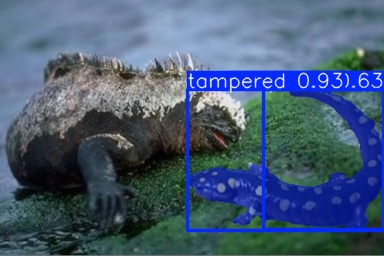

In [ ]:
from ultralytics import YOLO
import cv2
from google.colab.patches import cv2_imshow  # for showing in Colab
import os

# ==== 1. Load your trained model ====
model = YOLO("/content/CASIA Model.pt")  # update path to your .pt file

# ==== 2. Run prediction on a single image ====
results = model.predict(
    source="/content/casia_tp_1.jpg",  # path to your test image
    imgsz=512,         # match training size
    conf=0.25,         # confidence threshold
    save=True,         # save predictions (under runs/segment/predict/)
    save_txt=True,     # also save labels in YOLO format
    save_conf=True     # save confidences with labels
)

r = results[0]

# Get the saved prediction path
pred_img_path = os.path.join(r.save_dir, os.path.basename(r.path))

# Load and display in Colab
img = cv2.imread(pred_img_path)
cv2_imshow(img)


image 1/1 /content/CASIA image 2.jpg: 512x384 1 tampered, 14.9ms
Speed: 2.0ms preprocess, 14.9ms inference, 4.0ms postprocess per image at shape (1, 3, 512, 384)
Results saved to /content/runs/segment/predict4
1 label saved to /content/runs/segment/predict4/labels


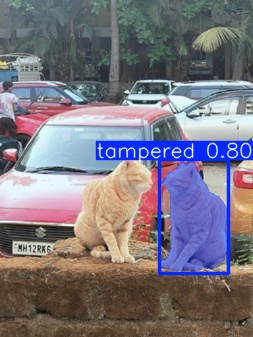

In [ ]:
from ultralytics import YOLO
import cv2
from google.colab.patches import cv2_imshow  # for showing in Colab
import os

# ==== 1. Load your trained model ====
model = YOLO("/content/CASIA Model.pt")  # update path to your .pt file

# ==== 2. Run prediction on a single image ====
results = model.predict(
    source="/content/CASIA image 2.jpg",  # path to your test image
    imgsz=512,         # match training size
    conf=0.5,         # confidence threshold
    save=True,         # save predictions (under runs/segment/predict/)
    save_txt=True,     # also save labels in YOLO format
    save_conf=True     # save confidences with labels
)

r = results[0]

# Get the saved prediction path
pred_img_path = os.path.join(r.save_dir, os.path.basename(r.path))

# Load and display in Colab
img = cv2.imread(pred_img_path)
cv2_imshow(img)


image 1/1 /content/0_000000000419.jpg: 384x512 1 tampered, 189.2ms
Speed: 2.2ms preprocess, 189.2ms inference, 9.1ms postprocess per image at shape (1, 3, 384, 512)
Results saved to /content/runs/segment/predict5
1 label saved to /content/runs/segment/predict5/labels


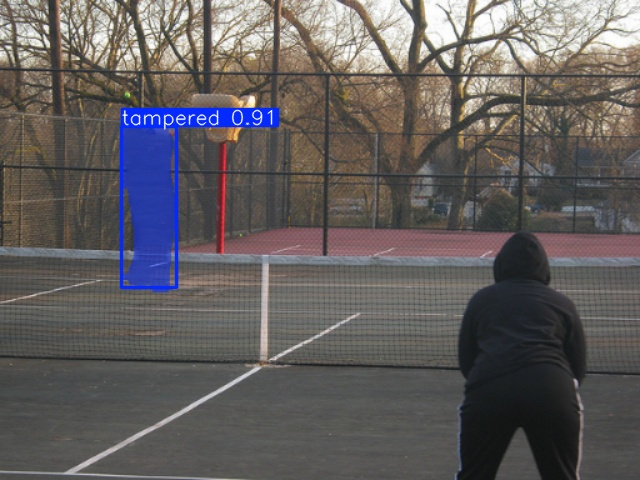

In [ ]:
from ultralytics import YOLO
import cv2
from google.colab.patches import cv2_imshow  # for showing in Colab
import os

# ==== 1. Load your trained model ====
model = YOLO("/content/Inpainting YOLO.pt")  # update path to your .pt file

# ==== 2. Run prediction on a single image ====
results = model.predict(
    source="/content/0_000000000419.jpg",  # path to your test image
    imgsz=512,         # match training size
    conf=0.25,         # confidence threshold
    save=True,         # save predictions (under runs/segment/predict/)
    save_txt=True,     # also save labels in YOLO format
    save_conf=True     # save confidences with labels
)

r = results[0]

# Get the saved prediction path
pred_img_path = os.path.join(r.save_dir, os.path.basename(r.path))

# Load and display in Colab
img = cv2.imread(pred_img_path)
cv2_imshow(img)


image 1/1 /content/inpainting ex 1.jpg: 512x320 1 tampered, 116.4ms
Speed: 2.0ms preprocess, 116.4ms inference, 3.6ms postprocess per image at shape (1, 3, 512, 320)
Results saved to /content/runs/segment/predict6
1 label saved to /content/runs/segment/predict6/labels


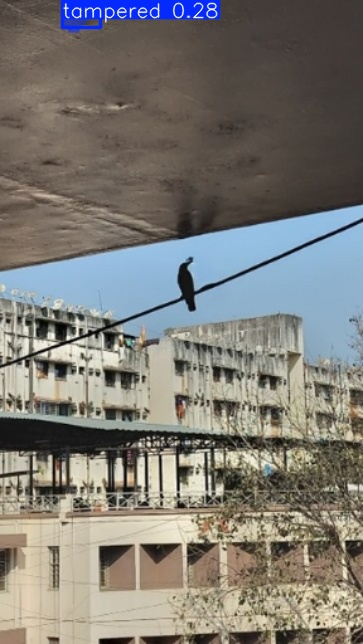

In [ ]:
from ultralytics import YOLO
import cv2
from google.colab.patches import cv2_imshow  # for showing in Colab
import os

# ==== 1. Load your trained model ====
model = YOLO("/content/Inpainting YOLO.pt")  # update path to your .pt file

# ==== 2. Run prediction on a single image ====
results = model.predict(
    source="/content/inpainting ex 1.jpg",  # path to your test image
    imgsz=512,         # match training size
    conf=0.25,         # confidence threshold
    save=True,         # save predictions (under runs/segment/predict/)
    save_txt=True,     # also save labels in YOLO format
    save_conf=True     # save confidences with labels
)

r = results[0]

# Get the saved prediction path
pred_img_path = os.path.join(r.save_dir, os.path.basename(r.path))

# Load and display in Colab
img = cv2.imread(pred_img_path)
cv2_imshow(img)